In [230]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import math
import re

from shapely.geometry import Polygon
from shapely.ops import cascaded_union

# VEST NE 2020

## VEST Documentation

### Sources

Election results from the Nebraska Secretary of State's office via email.

### Shapefiles

Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program, with the following exceptions.

Cass, Douglas, Harlan, and Lancaster replaced with maps from the counties.

Mergers and/or boundary shifts made based on county-sourced maps or geocoded voter files in Adams, Butler, Cuming, Custer, Dakota, Dawes, Dodge, Fillmore, Furnas, Hall, Keith, Keya Paha, Lincoln, Madison, Nemaha, Nuckolls, Phelps, Platte, Richardson, Saline, Scotts Bluff, and Seward.

Some counties reported one or more classes of votes at the county level. These were distributed by candidate based on the precinct-level reported vote.

### Races

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  

G20USSRSAS - Ben Sasse (Republican Party)  
G20USSDJAN - Chris Janicek (Democratic Party)  
G20USSLSLA - Gene Siadek (Libertarian Party)  

***

### Limitations

We encountered many issues with joining the results in Custer County due to a lack of correspondance between the returns on NE SOS's website and VEST's data. As a result, Custer County is not included in the validation that follows at this time. 

## Load in VEST file

In [231]:
vest_ne_2020 = gp.read_file("../vest/ne_2020/ne_2020.shp")

<AxesSubplot:>

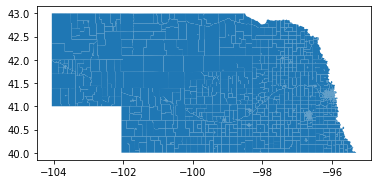

In [232]:
vest_ne_2020.plot()

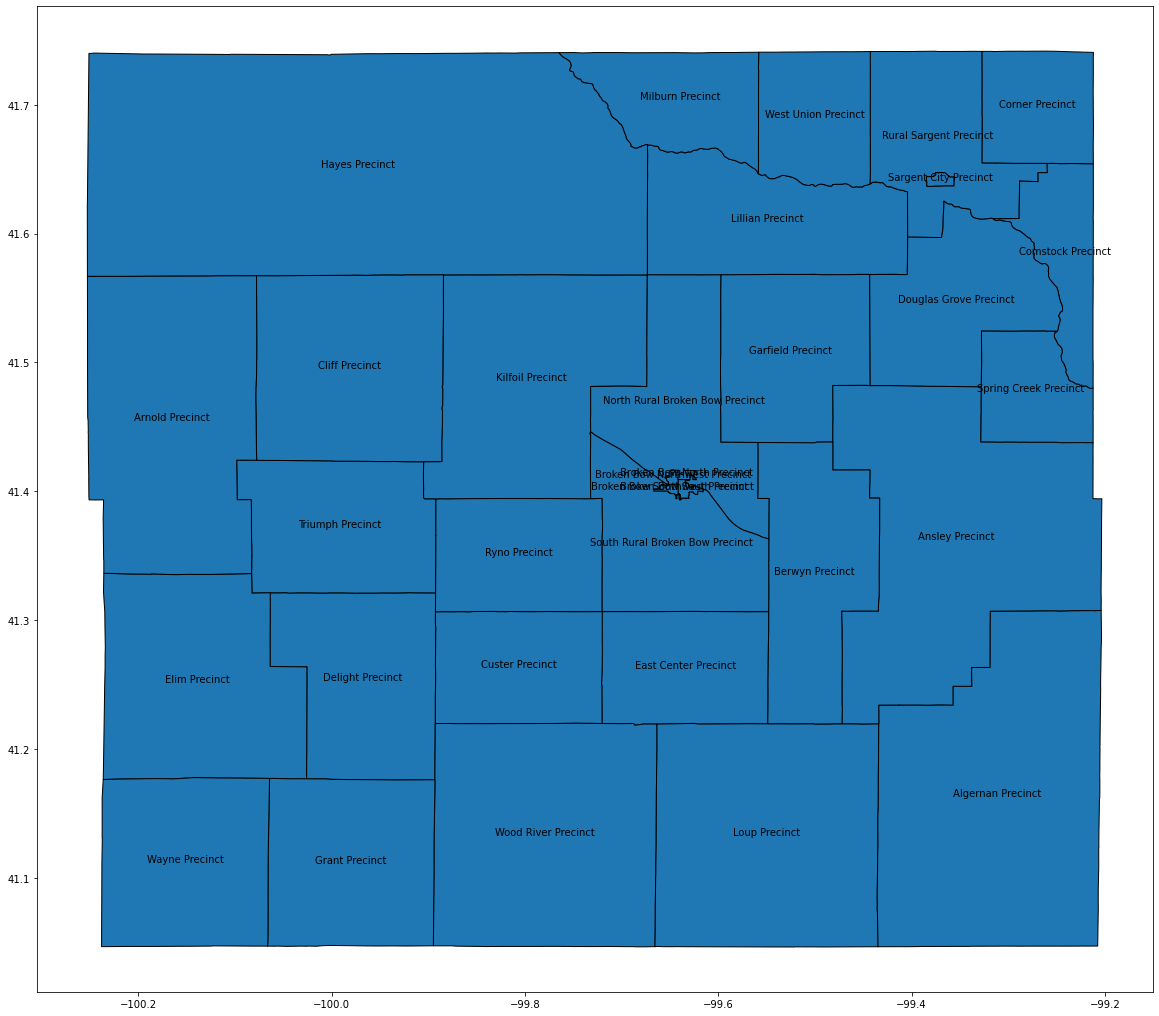

In [233]:
# A neat snippet that plots the labels of a geoseries onto its shapes. 
# Works great for examining individual counties for merges.

ax = vest_ne_2020.loc[vest_ne_2020['COUNTY'] == '041'].plot(figsize=(20,20), edgecolor='black')
vest_ne_2020.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

In [234]:
vest_ne_2020.loc[vest_ne_2020['COUNTY'] == '051']

,COUNTY,NAME,G20PRERTRU,G20PREDBID,G20PRELJOR,G20USSRSAS,G20USSDJAN,G20USSLSIA,geometry
837,051,Daily/Hooker/Newcastle Precinct,360,95,6,323,91,26,"POLYGON Z ((-97.01585 42.76134 0.00000, -97.01..."
838,051,Emerson Precinct,167,57,7,146,42,16,"POLYGON Z ((-96.78219 42.26411 0.00000, -96.78..."
839,051,Galena/Silvercreek Precinct,205,33,7,190,22,19,"POLYGON Z ((-96.89848 42.53930 0.00000, -96.89..."
840,051,Logan/Wakefield 3 Precinct,181,47,9,161,35,25,"POLYGON Z ((-96.78398 42.35006 0.00000, -96.78..."
841,051,Otter Precinct,103,30,4,90,26,5,"POLYGON Z ((-96.78386 42.42365 0.00000, -96.78..."
842,051,Ponca 1 Precinct,173,63,5,167,50,10,"POLYGON Z ((-96.72237 42.56792 0.00000, -96.71..."
843,051,Ponca 2 Precinct,187,58,12,180,38,22,"POLYGON Z ((-96.71653 42.56783 0.00000, -96.71..."
844,051,Ponca TWP/Ponca 3 Precinct,216,40,7,217,35,11,"POLYGON Z ((-96.78095 42.66355 0.00000, -96.77..."
845,051,Springbank Precinct,266,53,14,234,45,33,"POLYGON Z ((-96.90081 42.40372 0.00000, -96.90..."
846,051,Wakefield 2 Precinct,94,50,5,98,38,4,"POLYGON Z ((-96.87797 42.26652 0.00000, -96.87..."


In [235]:
races = [i for i in vest_ne_2020.columns if "G20" in i]

## Build table of precinct-level election results from NE SOS Spreadsheets

Extract a master list of Nebraska counties using the 2020 Presidential results spreadsheet.

In [236]:
import xlrd
pres_excel_df = pd.read_excel('../raw-from-source/2020-er/CountyResults-Presidential.xls', sheet_name='County Results', skiprows=5)

# throw out the bottom three rows (two rows of SOS formatting, one "total" row); extract county list.
pres_excel_df = pres_excel_df.loc[0:len(pres_excel_df)-4]
county_list = list(pres_excel_df['County'])

In [237]:
# The ends of the data tables are not consistent from sheet to sheet. 
# This function finds the correct ending row of a county data set, adds a 'County' column, 
# and returns a cleaned dataframe for this county. 
def clean_county_sheet(county_df, county_name):
    # Find the end of this data table by searching for the "TOTAL" row. 
    # Should return a list of exactly one number, which is the row index of the total row. 
    total_row_idx = list(county_excel_df.loc[county_excel_df['Precinct'] == 'TOTAL'].index)
    if len(total_row_idx) != 1:
        raise ValueError("Position of 'TOTAL' row could not be accurately inferred! (Found '{0}' suitable rows.)".format(len(total_row_idx)))

    # keep everything up to the total row 
    county_df = county_excel_df.loc[0:total_row_idx[0]-1].copy()
    county_df['County'] = county_name
    
    # clean leading/trailing whitespace from column names and precinct values
    county_df.columns = map(lambda e: e.strip(), list(county_df.columns))
    county_df['Precinct'] = county_df['Precinct'].apply(lambda e: e.strip())
    return county_df

Nebraska SOS distributes election results in spreadsheets, one for each statewide office on the ballot. Each county's results are broken down by precinct on a different page within the spreadsheet. 

In order to build a precinct-level data set of election results, we need to extract the precinct data from each master sheet (one for the presidential results, and one for the Senate results). Then we standardize the race results, and create one dataframe for each race. 

<b>NOTE:</b> 93 counties were missing one of the special precincts ('Countywide' or 'New/Former Resident') in their Senate race results, 1 county was missing a special precinct in its Presidential results. `ensure_special_precincts_exist(county_df, county_name, racetype)` fixes this problem by adding them back in where needed (with no votes).


In [238]:
# G20PRERTRU - Donald J. Trump (Republican Party)
# G20PREDBID - Joseph R. Biden (Democratic Party)
# G20PRELJOR - Jo Jorgensen (Libertarian Party)
pres_race_map = {
    'Joseph R. Biden and Kamala D. Harris': 'G20PREDBID',
    'Donald J. Trump and Michael R. Pence': 'G20PRERTRU',
    'Jo Jorgensen and Jeremy Cohen': 'G20PRELJOR'
}

# G20USSRSAS - Ben Sasse (Republican Party)
# G20USSDJAN - Chris Janicek (Democratic Party)
# G20USSLSIA - Gene Siadek (Libertarian Party)
sen_race_map = {
    'Gene Siadek': 'G20USSLSIA',
    'Ben Sasse': 'G20USSRSAS',
    'Chris Janicek': 'G20USSDJAN'   
}

# If dataframe contains precinct names that are identical, return the county dataframe with such precincts merged. 
def merge_duplicate_precincts(county_df, county_name):
    # Merge the vote totals for every column that looks like a race. Leave county and precinct as-is.
    # (This works for both Senate and Presidential after VEST race naming standards have been applied)
    all_races = [e for e in pres_race_map.values()] + [e for e in sen_race_map.values()]
    race_cols = list(filter(lambda e: e in all_races, list(county_df.columns)))
    print('merged duplicate precincts in {0} county'.format(county_name))
    return county_df.groupby(['County', 'Precinct'], as_index=False)[race_cols].sum()
    
# complain about duplicate precincts within a county
def detect_duplicate_precincts(county_df, county_name, racetype):
    # check if there are duplicated precincts in this county 
    if not county_df['Precinct'].is_unique:
        print('{} / {}: duplicate precincts detected in county! '.format(racetype, county_name))
    
# Ensures that a row for the two special precincts "Countywide" and "New/Former Resident" exists in the county dataframe.
# When it isn't there, adds a row with zero votes for all races for each missing special precinct.
# If data for all special precincts exists, returns the county dataframe with no changes.
#
# racetype is just a flag that's used for formatting the debugging output of this function.
def ensure_special_precincts_exist(county_df, county_name, racetype):
    dfs_to_append = []
    special_precincts = ['Countywide', 'New/Former Resident']
    for sp in special_precincts:
        if sp not in county_df['Precinct'].values:
            new_row_dict = {}
            new_row_dict['County'] = county_name
            new_row_dict['Precinct'] = sp
            # set the vote count for each race to zero.
            for col_name in filter(lambda e: e not in new_row_dict.keys(), list(county_df.columns)):
                new_row_dict[col_name] = 0
            dfs_to_append.append(pd.Series(new_row_dict))
            #print('{} / County `{}` has no `{}` precinct!'.format(racetype, county_name, sp))
            #print('+ Appending row: {}'.format([df.to_dict() for df in dfs_to_append]))
    if len(dfs_to_append) > 1:
        return pd.concat(objs=([county_df] + dfs_to_append))
    elif len(dfs_to_append) == 1:
        return county_df.append(dfs_to_append[0], ignore_index=True)
    else:
        return county_df

# construct each precinct-level county dataframe
pres_county_dfs = {}
sen_county_dfs = {}
for county in county_list:
    county_excel_df = pd.read_excel('../raw-from-source/2020-er/CountyResults-Presidential.xls', sheet_name=county, skiprows=5)
    county_df = clean_county_sheet(county_excel_df, county)
    county_df = county_df.rename(columns=pres_race_map)
    county_df = county_df[['County', 'Precinct', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR']]
    county_df = ensure_special_precincts_exist(county_df, county, 'PRESID')
    if not county_df['Precinct'].is_unique:
        county_df = merge_duplicate_precincts(county_df, county)
        pres_county_dfs[county] = county_df.copy()
    else:
        pres_county_dfs[county] = county_df.copy()
    #print("extracted '{0}' county presidential precinct results. (added '{1}' rows)".format(county, len(county_df)))
    
    # senate results
    county_excel_df = pd.read_excel('../raw-from-source/2020-er/CountyResults-Senate.xls', sheet_name=county, skiprows=5)
    county_df = clean_county_sheet(county_excel_df, county)
    county_df = county_df.rename(columns=sen_race_map)
    county_df = county_df[['County', 'Precinct', 'G20USSDJAN', 'G20USSRSAS', 'G20USSLSIA']]
    county_df = ensure_special_precincts_exist(county_df, county, 'SENATE')
    if not county_df['Precinct'].is_unique:
        county_df = merge_duplicate_precincts(county_df, county)
        sen_county_dfs[county] = county_df.copy()
    else:
        sen_county_dfs[county] = county_df.copy()
    #print("extracted '{0}' county senate precinct results. (added '{1}' rows)".format(county, len(county_df)))

merged duplicate precincts in Custer county
merged duplicate precincts in Custer county


Dixon County's presidential results contain two precincts that have been split by congressional district: `Logan-Wakefield 3` and `Emerson`. Leaving these splits as-is makes joining our results difficult since VEST did not observe these merges. Combine them before validation begins. 

The same thing happens with two precincts in Sarpy County (FIPS = 153).

In [239]:
# Merges rows within a set of precinct results. 
# 
# pcnts_to_merge: List of names/identifiers of rows to be merged.  
# pcnt_col_name: Name of the column that contains the values in 'pcnts_to_merge'. 
# race_cols: List of columns that contain vote counts that need to be combined (i.e. additively). 
# 
# It is assumed that all non-race columns will have *identical values* in each row to be merged, 
# and substitute them back into the merged row. If that's a problem, don't use this function!
#
# new_pcnt_name: Desired name/identifier of the newly merged precinct. 
# Will be written in the 'pcnt_col_name' column of the returned series. 
def merge_precincts(df, pcnts_to_merge, pcnt_col_name, race_cols, new_pcnt_name):
    race_totals = df.loc[df['Precinct'].isin(pcnts_to_merge)].sum()[race_cols]
    non_race_cols = df[list(filter(lambda e: e not in race_cols, df.columns))].to_dict('records')[0]
    new_row = {k:v for d in (non_race_cols, race_totals) for k, v in d.items()}
    new_row[pcnt_col_name] = new_pcnt_name
    return pd.Series(new_row)
    
race_cols = [e for e in pres_race_map.values()]

# Perform the Dixon County merges. 
dixon_df = pres_county_dfs['Dixon'].copy(deep=True)

# merge Logan-Wakefield 3 & Logan-Wakefield 3 (CG1) 
m = merge_precincts(dixon_df, ['Logan-Wakefield 3', 'Logan-Wakefield 3 (CG1)'], 'Precinct', race_cols, 'Logan-Wakefield 3')
dixon_df = dixon_df.loc[~(dixon_df['Precinct'].str.startswith('Logan-Wakefield'))]
dixon_df = dixon_df.append(m, ignore_index=True)

# merge Emerson & Emerson (CG1)
m = merge_precincts(dixon_df, ['Emerson', 'Emerson (CG1)'], 'Precinct', race_cols, 'Emerson')
dixon_df = dixon_df.loc[~(dixon_df['Precinct'].str.startswith('Emerson'))]
dixon_df = dixon_df.append(m, ignore_index=True)

# Use our new set of rows for Dixon County when compiling the source data set
pres_county_dfs['Dixon'] = dixon_df

# Perform Sarpy County merges. 
sarpy_df = pres_county_dfs['Sarpy'].copy(deep=True)

# merge Precinct 19 & Precinct 19 (CG1)
m = merge_precincts(sarpy_df, ['Precinct 19', 'Precinct 19 (CG1)'], 'Precinct', race_cols, 'Precinct 19')
sarpy_df = sarpy_df.loc[~(sarpy_df['Precinct'].str.startswith('Precinct 19'))]
sarpy_df = sarpy_df.append(m, ignore_index=True)

# merge Precinct 21 & Precinct 21 (CG1)
m = merge_precincts(sarpy_df, ['Precinct 21', 'Precinct 21 (CG1)'], 'Precinct', race_cols, 'Precinct 21')
sarpy_df = sarpy_df.loc[~(sarpy_df['Precinct'].str.startswith('Precinct 21'))]
sarpy_df = sarpy_df.append(m, ignore_index=True)

pres_county_dfs['Sarpy'] = sarpy_df

In [240]:
pres_results_df = pd.concat(pres_county_dfs.values()).reset_index(drop=True)
sen_results_df = pd.concat(sen_county_dfs.values()).reset_index(drop=True)
all_results_df = pres_results_df.merge(sen_results_df, how='left', left_on=['County', 'Precinct'], right_on=['County', 'Precinct'])

In [241]:
all_results_df.to_csv('../raw-from-source/2020-er/statewide-results-by-precinct.csv', index=False)

### Examination of Statewide Results 

Keeping track of data weirdness that may be breaking the joining process.

1. Dixon and Sarpy counties both have split "New/Former Resident" precincts. As of 10/8, I've merged the precincts together in the Nebraska SOS source spreadsheet.

> -- New/Former Resident 1 (Dixon, Sarpy)  <br>
> -- New/Former Resident 2 (Dixon, Sarpy) <br>

<b>NOTE:</b> Check with Peter to determine if modifying source data is the best practice for a situation like this. I could merge it later in the pipeline if source data from state governments must remain as-is.


2. Need to check to see if VEST lists these precincts in a single "Countywide" category, and merge them if so.

> -- (Countywide) Burt County PPD (Dodge) <br>
> -- (Countywide) Cuming PPD (Dodge, Wayne) <br>
> -- (Countywide) Nebraska PPD (Garden, Sheridan) <br>
> -- (Countywide) Loup Valleys Rural PPD (Greeley) <br>
> -- (Countywide) Elkhorn Rural PPD (Platte) <br>

3. Have to merge duplicated county precincts!

In [242]:
er_2020_df = pd.read_csv('../raw-from-source/2020-er/statewide-results-by-precinct.csv')

### Load in Raw Election Results

NOTE: This is just the file we created in the "Build table of precinct-level election results from NE SOS Spreadsheets" section above. 

Remove precincts in Custer County (FIPS: 041) from both data sets before we start validation.

In [243]:
er_2020_df = pd.read_csv('../raw-from-source/2020-er/statewide-results-by-precinct.csv')

In [244]:
er_2020_df = er_2020_df.loc[~(er_2020_df['County'] == 'Custer')].copy(deep=True)
vest_ne_2020 = vest_ne_2020.loc[~(vest_ne_2020['COUNTY'] == '041')].copy(deep=True)

In [245]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

### Validate statewide totals

In [246]:
races = ['G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20USSDJAN', 'G20USSRSAS', 'G20USSLSIA']
statewide_totals_check(er_2020_df,vest_ne_2020,races)

***Statewide Totals Check***
G20PREDBID is equal 	VEST / RDH: 373797.0
G20PRERTRU is equal 	VEST / RDH: 551756.0
G20PRELJOR is equal 	VEST / RDH: 20166.0
G20USSDJAN is equal 	VEST / RDH: 226660.0
G20USSRSAS is equal 	VEST / RDH: 578683.0
G20USSLSIA is equal 	VEST / RDH: 54754.0


Convert 'County' column on our results to a FIPS column.

In [247]:
fips_df = pd.read_csv('../raw-from-source/US_FIPS_CODES.csv')
ne_fips_df = fips_df.loc[fips_df['FIPS State'] == 31]
fl = ne_fips_df[['FIPS County', 'County Name']].to_dict('list')
fips_dict = dict(zip(fl['County Name'], fl['FIPS County']))
er_2020_df['FIPS'] = er_2020_df['County'].apply(lambda e: str(fips_dict[e]).zfill(3)).copy()
er_2020_df = er_2020_df[['FIPS', 'Precinct', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20USSDJAN', 'G20USSRSAS', 'G20USSLSIA']]
er_2020_df = er_2020_df.rename(columns={'FIPS':'COUNTY', 'Precinct': 'NAME'})
ne_2020_df = er_2020_df[['COUNTY', 'NAME', 'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20USSRSAS', 'G20USSDJAN', 'G20USSLSIA']]

In [248]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

### Validate County Totals

In [249]:
county_totals_check(vest_ne_2020, ne_2020_df, races, 'COUNTY', full_print=False)

***Countywide Totals Check***

G20PREDBID is equal across all counties
G20PRERTRU is equal across all counties
G20PRELJOR is equal across all counties
G20USSDJAN is equal across all counties
G20USSRSAS is equal across all counties
G20USSLSIA is equal across all counties


### Precinct Validation

Do prep work before merging

In [250]:
# converts FIPS value corresponding to a county within Nebraska to its county name
fips_df = pd.read_csv('../raw-from-source/US_FIPS_CODES.csv')
ne_fips_df = fips_df.loc[fips_df['FIPS State'] == 31]
fl = ne_fips_df[['FIPS County', 'County Name']].to_dict('list')
fips_padded_list = list(map(lambda e: str(e).zfill(3), fl['FIPS County']))
fips_dict = dict(zip(fips_padded_list, fl['County Name']))

In [251]:
# uppercase all precinct names in both frames
ne_2020_df['NAME'] = ne_2020_df['NAME'].apply(lambda e: e.upper())
vest_ne_2020['NAME'] = vest_ne_2020['NAME'].apply(lambda e: e.upper())

Remove precincts from the source data set that contain votes that need to be re-allocated. These include precincts labeled as

- Countywide
- New/Former Resident
- (Countywide) \S+

In [252]:
ne_2020_df.shape

(1548, 8)

In [253]:
list(ne_2020_df["NAME"].unique())

['WESTBLUE/HIGHLAND',
 'VERONA',
 'KENESAW',
 'JUNIATA',
 'DENVER',
 'BLAINE',
 'PAULINE',
 'AYR',
 'ROSELAND',
 'HOLSTEIN',
 '1-A',
 '1-B',
 '1-C',
 '2-A',
 '2-B',
 '2-C',
 '2-D',
 '2-E',
 '3-A',
 '3-B',
 '3-C',
 '3-D',
 '3-E',
 '4-A',
 '4-B',
 '4-C',
 '4-D',
 '4-E',
 'NEW/FORMER RESIDENT',
 'COUNTYWIDE',
 'TILDEN PRECINCT',
 'TILDEN 1ST WARD',
 'OAKDALE PRECINCT',
 'NELIGH PRECINCT',
 'NELIGH 1ST WARD',
 'NELIGH 2ND WARD',
 'BRUNSWICK PRECINCT',
 'ELGIN 1ST WARD',
 'ELGIN 2ND WARD',
 'ELGIN PRECINCT',
 'ROYAL PRECINCT',
 'CLEARWATER PRECINCT',
 'ORCHARD PRECINCT',
 'ARTHUR',
 'LONG SPRINGS',
 'BOONE',
 'BEAVER',
 'CEDAR',
 'DUBLIN-BONANZA',
 'NORTH BRANCH-SHELL CREEK',
 'NORTH MANCHESTER',
 'OAKLAND',
 'SOUTHEAST MANCHESTER',
 'SOUTHWEST MANCHESTER',
 'PRECINCT 1',
 'PRECINCT 2',
 'PRECINCT 3',
 'PRECINCT 4',
 'PRECINCT 5',
 'PRECINCT 6',
 'PRECINCT 11',
 'PRECINCT 12',
 'PRECINCT 15',
 'BUTTE BASIN MCCULLEY',
 'LYNCH BRISTOW MULLEN BUSH',
 'SPENCER MORTON',
 'AINSWORTH PRECINCT',
 '

In [254]:
to_reallocate_df = ne_2020_df.loc[ne_2020_df['NAME'].isin(['COUNTYWIDE', 'NEW/FORMER RESIDENT']) | ne_2020_df['NAME'].str.startswith('(COUNTYWIDE)')]
ne_2020_df = pd.concat([ne_2020_df, to_reallocate_df]).drop_duplicates(keep=False)

In [255]:
print(to_reallocate_df.shape)
print(ne_2020_df.shape)

(192, 8)
(1356, 8)


In [271]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [256]:
ne_2020_df = allocate_absentee(ne_2020_df,to_reallocate_df,races,"COUNTY")

In [257]:
to_reallocate_df.groupby(["COUNTY"]).sum()

,G20PRERTRU,G20PREDBID,G20PRELJOR,G20USSRSAS,G20USSDJAN,G20USSLSIA
COUNTY,,,,,,
001,2.0,5.0,0.0,0.0,0.0,0.0
003,0.0,0.0,0.0,0.0,0.0,0.0
005,260.0,21.0,3.0,228.0,21.0,21.0
007,0.0,0.0,0.0,0.0,0.0,0.0
009,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
177,5.0,0.0,0.0,0.0,0.0,0.0
179,0.0,0.0,0.0,0.0,0.0,0.0
181,6.0,1.0,0.0,0.0,0.0,0.0


In [258]:
to_reallocate_df[to_reallocate_df["COUNTY"]=="005"]

,COUNTY,NAME,G20PRERTRU,G20PREDBID,G20PRELJOR,G20USSRSAS,G20USSDJAN,G20USSLSIA
46,005,NEW/FORMER RESIDENT,0.0,0.0,0.0,0.0,0.0,0.0
47,005,COUNTYWIDE,260.0,21.0,3.0,228.0,21.0,21.0


In [259]:
ne_2020_df[ne_2020_df["COUNTY"]=="005"]

,COUNTY,NAME,G20PRERTRU,G20PREDBID,G20PRELJOR,G20USSRSAS,G20USSDJAN,G20USSLSIA
45,005,ARTHUR,0,0,0,0,0,0


In [260]:
ne_2020_df.loc[ne_2020_df["COUNTY"]=="005","G20PRERTRU"]=260
ne_2020_df.loc[ne_2020_df["COUNTY"]=="005","G20PREDBID"]=21
ne_2020_df.loc[ne_2020_df["COUNTY"]=="005","G20PRELJOR"]=3
ne_2020_df.loc[ne_2020_df["COUNTY"]=="005","G20USSRSAS"]=228
ne_2020_df.loc[ne_2020_df["COUNTY"]=="005","G20USSDJAN"]=21
ne_2020_df.loc[ne_2020_df["COUNTY"]=="005","G20USSLSIA"]=21

In [261]:
to_reallocate_df = to_reallocate_df[to_reallocate_df["COUNTY"]!="005"]

Assign unique ID to each row in both data sets by joining county and precinct name

In [262]:
## NOTES FOR NEXT ELECTION YEAR AND ALL OTHER PDV WORK -- WHEN BUILDING UNIQUEID STRING, 
## INCLUDE PRECINCT NUMBER AND ZERO PAD IT! DO NOT CONCATENATE AS AN INT! 
## LEXICOGRAPHIC SORTING WILL WORK BETTER THIS WAY AND IT SHOULD BE EASIER TO BUILD THE MAPPING DICTIONARY!

vest_ne_2020["unique_ID"] = vest_ne_2020["COUNTY"] + "-" + vest_ne_2020["NAME"]
ne_2020_df["unique_ID"] = ne_2020_df["COUNTY"] + "-" + ne_2020_df["NAME"]

Perform first merge and check the results

In [263]:
merged_1_df = pd.merge(vest_ne_2020, ne_2020_df, how='outer', on="unique_ID", indicator=True, validate='1:1').copy(deep=True)

# Compare the number of rows with NaN values (failed joins) against the number without any (successful joins). 
nan_rows = merged_1_df[merged_1_df.isnull().any(axis=1)]
valid_rows = merged_1_df[~merged_1_df.isnull().any(axis=1)]
print('NaN rows: {0}, Valid rows: {1} -> joined {2}%'.format(len(nan_rows), len(valid_rows), (len(valid_rows)/(len(nan_rows)+len(valid_rows)))*100))
print(merged_1_df["_merge"].value_counts())

NaN rows: 2003, Valid rows: 353 -> joined 14.9830220713073%
right_only    1003
left_only     1000
both           353
Name: _merge, dtype: int64


Apply the source precinct -> VEST precinct ID mapping

In [264]:
# Uncomment to load in a new mapping from CSV and print it so it can be copy and pasted below. 
#
# d = pd.read_csv('../raw-from-source/2020-er/final-source-to-vest-mapping.csv').to_dict('list')
# s2v = dict(zip(d['Source ID'], d['VEST ID']))
# print(s2v)

In [265]:
nan = np.nan
s2v = {'001-1-A': '001-1A', '001-1-B': '001-1B', '001-1-C': '001-1C', '001-2-A': '001-2A', '001-2-B': '001-2B', '001-2-C': '001-2C', '001-2-D': '001-2D', '001-2-E': '001-2E', '001-3-A': '001-3A', '001-3-B': '001-3B', '001-3-C': '001-3C', '001-3-D': '001-3D', '001-3-E': '001-3E', '001-4-A': '001-4A', '001-4-B': '001-4B', '001-4-C': '001-4C', '001-4-D': '001-4D', '001-4-E': '001-4E', '001-JUNIATA': '001-JUNIATA PRECINCT', '001-WESTBLUE/HIGHLAND': '001-HIGHLAND_WEST_BLUE', '003-NELIGH 1ST WARD': '003-NELIGH CITY 1ST WARD', '003-NELIGH 2ND WARD': '003-NELIGH CITY 2ND WARD', '005-ARTHUR': '005-ARTHUR PRECINCT', '007-LONG SPRINGS': '007-LONG SPRINGS PRECINCT', '009-BLAINE': '009-BLAINE PRECINCT', '011-BEAVER': '011-BEAVER PRECINCT', '011-BOONE': '011-BOONE PRECINCT', '011-CEDAR': '011-CEDER PRECINCT', '011-DUBLIN-BONANZA': '011-DUBLIN-BONANZA PRECINCT', '011-NORTH BRANCH-SHELL CREEK': '011-NORTH BRANCH-SHELL CREEK PRECINCT', '011-NORTH MANCHESTER': '011-NORTH MANCHESTER PRECINCT', '011-OAKLAND': '011-OAKLAND PRECINCT', '011-SOUTHEAST MANCHESTER': '011-SOUTHEAST MANCHESTER PRECINCT', '011-SOUTHWEST MANCHESTER': '011-SOUTHWEST MANCHESTER PRECINCT', '013-PRECINCT 1': '013-VOTING PRECINCT 1', '013-PRECINCT 11': '013-VOTING PRECINCT 11', '013-PRECINCT 12': '013-VOTING PRECINCT 12', '013-PRECINCT 15': '013-VOTING PRECINCT 15', '013-PRECINCT 2': '013-VOTING PRECINCT 2', '013-PRECINCT 3': '013-VOTING PRECINCT 3', '013-PRECINCT 4': '013-VOTING PRECINCT 4', '013-PRECINCT 5': '013-VOTING PRECINCT 5', '013-PRECINCT 6': '013-VOTING PRECINCT 6', '015-BUTTE BASIN MCCULLEY': '015-BASIN - MCCULLEY - BUTTE PRECINCT', '015-LYNCH BRISTOW MULLEN BUSH': '015-BRISTOW - MULLEN - LYNCH - BUSH PRECINCT', '015-SPENCER MORTON': '015-SPENCER - MORTON PRECINCT', '017-CITY OF AINSWORTH': '017-CITY OF AINSWORTH PRECINCT', '017-THE PINES': '017-PINES PRECINCT', '019-PRECINCT 7': '019-PRECINT 7', '021-BELL-OAK-PERSH': '021-BELLCREEK-OAKLAND-PERSHING PRECINCT', '021-CRAIG': '021-CRAIG PRECINCT', '021-DECATUR-QUINN': '021-DECATUR-QUINBAUGH PRECINCT', '021-EVERETT-LOGAN': '021-EVERETT-LOGAN PRECINCT', '021-LYONS CITY': '021-LYONS PRECINCT', '021-OAKLAND I': '021-OAKLAND CITY 1', '021-OAKLAND II': '021-OAKLAND CITY 2', '021-SILVERCREEK-SUMMIT': '021-SILVER CREEK-SUMMIT PRECINCT', '021-TEKAMAH I': '021-TEKAMAH 1', '021-TEKAMAH II': '021-TEKAMAH 2', '023-FIRST WARD': '023-DAVID CITY WARD 1', '023-FRANKLIN-BONE CREEK': '023-FRANKLIN-BONE CREEK PRECINCT', '023-LINWOOD-SKULL CREEK-PLATTE': '023-LINWOOD-SKULL CREEK - PLATTE PRECINCT', '023-OAK CREEK-CENTER': '023-OAK CREEK-CENTER PRECINCT', '023-PLUM CREEK-RICHARDSON': '023-PLUM CREEK-RICHARDSON PRECINCT', '023-READ-ULYSSES': '023-READ-ULYSSES PRECINCT', '023-SAVANNAH-ALEXIS': '023-SAVANNAH-ALEXIS PRECINCT', '023-SECOND WARD': '023-DAVID CITY WARD 2', '023-SUMMIT-READING': '023-SUMMIT-READING PRECINCT', '023-THIRD WARD': '023-DAVID CITY WARD 3', '023-UNION-OLIVE': '023-UNION-OLIVE PRECINCT', '025-1ST WARD - 1ST PRECINCT': '025-PLATTSMOUTH_1_WARD_1_PRECINCT', '025-1ST WARD - 2ND PRECINCT': '025-PLATTSMOUTH_1_WARD_2_PRECINCT', '025-2ND WARD - 1ST PRECINCT': '025-PLATTSMOUTH_2_WARD_1_PRECINCT', '025-2ND WARD - 2ND PRECINCT': '025-PLATTSMOUTH_2_WARD_2_PRECINCT', '025-3RD WARD - 1ST PRECINCT': '025-PLATTSMOUTH_3_WARD_1_PRECINCT', '025-3RD WARD - 2ND PRECINCT': '025-PLATTSMOUTH_3_WARD_2_PRECINCT', '025-4TH WARD - 1ST PRECINCT': '025-PLATTSMOUTH_4_WARD_1_PRECINCT', '025-4TH WARD - 2ND PRECINCT': '025-PLATTSMOUTH_4_WARD_2_PRECINCT', '025-BUCCANEER BAY': '025-BUCCANEER_BAY', '025-EAST LOUISVILLE': '025-EAST_LOUISVILLE', '025-EIGHT MILE GROVE': '025-EIGHT_MILE_GROVE', '025-MOUNT PLEASANT': '025-MOUNT_PLEASANT', '025-NORTH PLATTSMOUTH': '025-NORTH_PLATTSMOUTH', '025-NORTH ROCK BLUFF': '025-NORTH_ROCK_BLUFF', '025-SALT CREEK': '025-SALT_CREEK', '025-SOUTH BEND': '025-SOUTH_BEND', '025-SOUTH PLATTSMOUTH': '025-SOUTH_PLATTSMOUTH', '025-SOUTH ROCK BLUFF': '025-SOUTH_ROCK_BLUFF', '025-STOVE CREEK': '025-STOVE_CREEK', '025-WEEPING WATER 1ST WARD': '025-WEEPING_WATER_WARD_1', '025-WEEPING WATER 2ND WARD': '025-WEEPING_WATER_WARD_2', '025-WEST LOUISVILLE': '025-WEST_LOUISVILLE', '025-WEST ROCK BLUFF': '025-WEST_ROCK_BLUFF', '027-PRECICNT 10 (17-18)': '027-PRECINCT 10', '027-PRECICNT 13 (21)': '027-PRECINCT 13', '027-PRECICNT 3 (4)': '027-PRECINCT 3', '027-PRECICNT 4 (5-6-7)': '027-PRECINCT 4', '027-PRECICNT 7 (9A)': '027-PRECINCT 7', '027-PRECINCT 1 (1)': '027-PRECINCT 1', '027-PRECINCT 11 (19)': '027-PRECINCT 11', '027-PRECINCT 12 (20)': '027-PRECINCT 12', '027-PRECINCT 2 (2-3)': '027-PRECINCT 2', '027-PRECINCT 5 (13-14)': '027-PRECINCT 5', '027-PRECINCT 6 (8-9)': '027-PRECINCT 6', '027-PRECINCT 8 (10-11-12)': '027-PRECINCT 8', '027-PRECINCT 9 (15-16)': '027-PRECINCT 9', '029-CHAMPION/LAMAR': '029-CHAMPION/LAMAR PRECINCT', '029-IMPERIAL EAST': '029-IMPERIAL EAST PRECINCT', '029-IMPERIAL RURAL': '029-IMPERIAL RURAL PRECINCT', '029-IMPERIAL WEST': '029-IMPERIAL WEST PRECINCT', '029-WAUNETA': '029-WAUNETA PRECINCT', '031-BARLEY': '031-BARLEY PRECINCT', '031-CLEVELAND': '031-CLEVELAND PRECINCT', '031-CODY': '031-CODY PRECINCT', '031-CROOKSTON': '031-CROOKSTON PRECINCT', '031-GILLASPIE': '031-GILLASPIE PRECINCT', '031-GOOSE CREEK': '031-GOOSE CREEK PRECINCT', '031-KENNEDY': '031-KENNEDY PRECINCT', '031-KILGORE': '031-KILGORE PRECINCT', '031-KING': '031-KING PRECINCT', '031-LACKEY': '031-LACKEY PRECINCT', '031-LOUP': '031-LOUP PRECINCT', '031-MERRIMAN': '031-MERRIMAN PRECINCT', '031-MOTHER LAKE': '031-MOTHER LAKE PRECINCT', '031-NENZEL': '031-NENZEL PRECINCT', '031-RUSSELL': '031-RUSSELL PRECINCT', '031-VALENTINE EAST': '031-EAST VALENTINE PRECINCT', '031-VALENTINE NORTH': '031-NORTH VALENTINE PRECINCT', '031-VALENTINE SOUTH': '031-SOUTH VALENTINE PRECINCT', '031-WELLS': '031-WELLS PRECINCT', '031-WOOD LAKE': '031-WOOD LAKE PRECINCT', '033-GURLEY': '033-GURLEY PRECINCT', '033-LODGEPOLE': '033-LODGEPOLE PRECINCT', '033-POTTER': '033-POTTER PRECINCT', '033-SIDNEY 1': '033-SIDNEY PRECINCT 1', '033-SIDNEY 2': '033-SIDNEY PRECINCT 2', '033-SIDNEY 3': '033-SIDNEY PRECINCT 3', '033-SIDNEY 4': '033-SIDNEY PRECINCT 4', '033-SIDNEY 5': '033-SIDNEY PRECINCT 5', '033-UNION VALLEY': '033-UNION VALLEY PRECINCT', '035-CLAY CENTER CITY': '035-CLAY CENTER PRECINCT', '035-EDGAR CONS.': '035-EDGAR CONS. PRECINCT', '035-FAIRFIELD 1ST': '035-FAIRFIELD PRECINCT', '035-GLENVIL': '035-GLENVIL PRECINCT', '035-HARVARD CONS.': '035-HARVARD PRECINCT', '035-INLAND LEICESTER': '035-LEICESTER/INLAND PRECINCT', '035-LLLM CONS.': '035-L.L.L.M. CONS PRECINCT', '035-SPRING RANCH FF 2ND': '035-SPRING RANCH/FAIRFIELD PRECINCT', '035-SUTTON 1ST': '035-SUTTON 1ST PRECINCT', '035-SUTTON 2ND': '035-SUTTON 2ND PRECINCT', '035-SUTTON TWPS': '035-SUTTON TWPS PRECINCT', '037-CLARKSON 4': '037-4 PRECINCT', '037-HOWELLS 5': '037-5 PRECINCT', '037-SCHUYLER 1': '037-1 PRECINCT', '037-SCHUYLER 2': '037-2 PRECINCT', '037-SCHUYLER 3': '037-3 PRECINCT', '039-BCN': '039-BANCROFT, CLEVELAND & NELIGH PRECINCT', '039-BGW': '039-WISNER, BLAINE & GRANT PRECINCT', '039-BL': '039-BEEMER & LOGAN PRECINCT', '039-SSGC': '039-ST. CHARLES SHERMAN GARFIELD & CUMING PRECINCT', '039-SW4': '039-SW 4', '039-WP1&3': '039-WEST POINT WARD 1 & 3', '039-WP2': '039-WEST POINT WARD 2', '041-ANSELMO': '041-HAYES PRECINCT', '041-ANSLEY/M/W': '041-ANSLEY PRECINCT', '041-ARNOLD': '041-ARNOLD PRECINCT', '041-BB NORTHWEST': '041-BROKEN BOW NORTHWEST PRECINCT', '041-BB SOUTH RURAL': '041-SOUTH RURAL BROKEN BOW PRECINCT', '041-BERWYN': '041-BERWYN PRECINCT', '041-BROKEN BOW NORTH': '041-BROKEN BOW NORTH PRECINCT', '041-BROKEN BOW NORTH RURAL': '041-NORTH RURAL BROKEN BOW PRECINCT', '041-BROKEN BOW NORTHWEST': '041-BROKEN BOW NORTHWEST PRECINCT', '041-BROKEN BOW SOUTH': '041-BROKEN BOW SOUTH PRECINCT', '041-BROKEN BOW SOUTH RURAL': '041-SOUTH RURAL BROKEN BOW PRECINCT', '041-BROKEN BOW SOUTHWEST': '041-BROKEN BOW SOUTHWEST PRECINCT', '041-COMSTOCK/DG/SC': nan, '041-CUSTER': '041-CUSTER PRECINCT', '041-DELIGHT': '041-DELIGHT PRECINCT', '041-EAST CUSTER': '041-EAST CENTER PRECINCT', '041-ELIM': '041-ELIM PRECINCT', '041-GRANT': '041-GRANT PRECINCT', '041-LOUP': '041-LOUP PRECINCT', '041-MASON CITY': '041-ALGERNAN PRECINCT', '041-MERNA COMMUNITY BLDG': '041-KILFOIL PRECINCT', '041-RYNO': '041-RYNO PRECINCT', '041-SARGENT VILLAGE': '041-SARGENT CITY PRECINCT', '041-TRIUMPH': '041-TRIUMPH PRECINCT', '041-WAYNE': '041-WAYNE PRECINCT', '041-WOODRIVER': '041-WOOD RIVER PRECINCT', '043-01 - SSC WARD 1': '043-SOUTH SIOUX CITY 1 PRECINCT', '043-02 - SSC WARD 2': '043-SOUTH SIOUX CITY 2 PRECINCT', '043-03 - SSC WARD 3': '043-SOUTH SIOUX CITY 3A PRECINCT', '043-04 - SSC WARD 4A': '043-SOUTH SIOUX CITY 4A PRECINCT', '043-05 - SSC WARD 4AA': '043-SOUTH CITY PRECINCT PRECINCT 4AA', '043-06 - SSC WARD 4B': '043-SOUTH SIOUX CITY 4B PRECINCT', '043-07 - COVINGTON ISLAND': '043-COVINGTON ISLAND PRECINCT', '043-08 - DAKOTA CITY': '043-DAKOTA CITY PRECINCT', '043-09 - DAKOTA RURAL': '043-DAKOTA RURAL PRECINCT', '043-10 - EMERSON': '043-EMERSON PRECINCT', '043-11 - HUBBARD': '043-HUBBARD PRECINCT', '043-12 - OMADI': '043-OMADI PRECINCT', '043-13 - ST. JOHNS': "043-ST. JOHN'S PRECINCT", '045-PRECINCT 1': '045-#1 PRECINCT', '045-PRECINCT 10': '045-#10 PRECINCT', '045-PRECINCT 11': '045-#11 PRECINCT', '045-PRECINCT 2': '045-#2 PRECINCT', '045-PRECINCT 3': '045-#3 PRECINCT', '045-PRECINCT 4': '045-#4 PRECINCT', '045-PRECINCT 5': '045-#5 PRECINCT', '045-PRECINCT 6': '045-#6 PRECINCT', '045-PRECINCT 7': '045-#7 PRECINCT', '045-PRECINCT 8': '045-#8 PRECINCT', '045-PRECINCT 9': '045-#9 PRECINCT', '047-COYOTE': '047-COYOTE PRECINCT', '047-COZAD EAST': '047-COZAD EAST PRECINCT', '047-COZAD WEST': '047-COZAD WEST PRECINCT', '047-FAIRVIEW': '047-FAIRVIEW PRECINCT', '047-FARNAM': '047-FARNAM PRECINCT', '047-GERMAN': '047-GERMAN PRECINCT', '047-GILLAN': '047-GILLAN PRECINCT', '047-GOTHENBURG EAST': '047-GOTHENBURG EAST PRECINCT', '047-GOTHENBURG WEST': '047-GOTHENBURG WEST PRECINCT', '047-GRANT': '047-GRANT PRECINCT', '047-KENNEBEC': '047-KENNEBEC PRECINCT', '047-LEXINGTON 1ST': '047-LEXINGTON 1ST PRECINCT', '047-LEXINGTON 2ND': '047-LEXINGTON 2ND PRECINCT', '047-LEXINGTON 3RD': '047-LEXINGTON 3RD PRECINCT', '047-LEXINGTON 4TH': '047-LEXINGTON 4TH PRECINCT', '047-LEXINGTON 5TH': '047-LEXINGTON 5TH PRECINCT', '047-OVERTON': '047-OVERTON PRECINCT', '047-PLATTE': '047-PLATTE PRECINCT', '047-RINGGOLD': '047-RINGGOLD PRECINCT', '047-WOODRIVER': '047-WOODRIVER PRECINCT', '049-BIG SPRINGS': '049-BIG SPRINGS PRECINCT', '049-CHAPPELL': '049-CHAPPELL PRECINCT', '049-SWAN': '049-SWAN PRECINCT', '051-CONCORD-DIXON-CLARK': '051-CONCORD/DIXON/CLARK PRECINCT', '051-DAILY-HOOKER-NEWCASTLE': '051-DAILY/HOOKER/NEWCASTLE PRECINCT', '051-EMERSON': '051-EMERSON PRECINCT', '051-EMERSON (CG1)': '051-EMERSON PRECINCT', '051-GALENA-SILVERCREEK': '051-GALENA/SILVERCREEK PRECINCT', '051-LOGAN-WAKEFIELD 3': '051-LOGAN/WAKEFIELD 3 PRECINCT', '051-LOGAN-WAKEFIELD 3 (CG1)': '051-LOGAN/WAKEFIELD 3 PRECINCT', '051-OTTERCREEK': '051-OTTER PRECINCT', '051-PONCA 1': '051-PONCA 1 PRECINCT', '051-PONCA 2': '051-PONCA 2 PRECINCT', '051-PONCA TOWNSHIP': '051-PONCA TWP/PONCA 3 PRECINCT', '051-SPRINGBANK': '051-SPRINGBANK PRECINCT', '051-WAKEFIELD 1': '051-WAKEFIELD 1 PRECINCT', '051-WAKEFIELD 2': '051-WAKEFIELD 2 PRECINCT', '053-CITY OF HOOPER': '053-HOOPER CITY PRECINCT', '053-CITY OF NORTH BEND': '053-NORTH BEND VILLAGE PRECINCT', '053-CITY OF SCRIBNER': '053-SCRIBNER CITY PRECINCT', '053-CUMING/EVERETT TOWNSHIPS': '053-CUMING-EVERETT PRECINCT', '053-ELKHORN TOWNSHIP': '053-ELKHORN PRECINCT', '053-FREMONT 1A': '053-FREMONT PRECINCT 1A', '053-FREMONT 1B': '053-FREMONT PRECINCT 1B', '053-FREMONT 1C': '053-FREMONT PRECINCT 1C', '053-FREMONT 1D': '053-FREMONT PRECINCT 1D', '053-FREMONT 1E': '053-FREMONT PRECINCT 1E', '053-FREMONT 2A': '053-FREMONT PRECINCT 2A', '053-FREMONT 2B': '053-FREMONT PRECINCT 2B', '053-FREMONT 2C': '053-FREMONT PRECINCT 2C', '053-FREMONT 2D': '053-FREMONT PRECINCT 2D', '053-FREMONT 2E': '053-FREMONT PRECINCT 2E', '053-FREMONT 3A': '053-FREMONT PRECINCT 3A', '053-FREMONT 3B': '053-FREMONT PRECINCT 3B', '053-FREMONT 3C': '053-FREMONT PRECINCT 3C', '053-FREMONT 3D': '053-FREMONT PRECINCT 3D', '053-FREMONT 3E': '053-FREMONT PRECINCT 3E', '053-FREMONT 4A': '053-FREMONT PRECINCT 4A', '053-FREMONT 4B': '053-FREMONT PRECINCT 4B', '053-FREMONT 4C': '053-FREMONT PRECINCT 4C', '053-FREMONT 4D': '053-FREMONT PRECINCT 4D', '053-FREMONT 4E': '053-FREMONT PRECINCT 4E', '053-HOOPER/LOGAN TOWNSHIPS': '053-LOGAN-HOOPER PRECINCT', '053-NICKERSON/MAPLE TOWNSHIPS': '053-MAPLE-NICKERSON PRECINCT', '053-PEBBLE TOWNSHIP': '053-PEBBLE PRECINCT', '053-PLATTE EAST': '053-PLATTE EAST PRECINCT', '053-PLATTE WEST': '053-PLATTE WEST PRECINCT', '053-UNION/COTT/RIDG/PV TOWNSHIPS': '053-RIDGELY-UNION-COTTERELL PRECINCT- PLEASANT VALLEY', '053-WEBSTER TOWNSHIP': '053-WEBSTER PRECINCT', '057-BENKELMAN I & OUGH': '057-BENKELMAN I/OUGH', '059-CHELSEA/STANTON/BELLE PRAIRIE': '059-#109 PRECINCT', '059-EXETER TOWNSHIP': '059-#101 PRECINCT', '059-FAIRMONT TOWNSHIP': '059-#102 PRECINCT', '059-LIBERTY/GLENGARY/FRANKLIN': '059-#108 PRECINCT', '059-MADISON TOWNSHIP': '059-#107 PRECINCT', '059-MOMENCE/BRYANT/HAMILTON': '059-#110 PRECINCT', '059-NORTH GENEVA': '059-#105 PRECINCT', '059-SOUTH GENEVA & GENEVA TOWNSHIP': '059-#104 PRECINCT', '059-WEST BLUE/GRAFTON/BENNETT': '059-#103 PRECINCT', '061-CAMPBELL': '061-CAMPBELL PRECINCT', '061-EAST FRANKLIN': '061-EAST FRANKLIN PRECINCT', '061-HILDRETH': '061-HILDRETH PRECINCT', '061-WEST FRANKLIN': '061-WEST FRANKLIN PRECINCT', '063-CURTIS': '063-CURTIS PRECINCT', '063-EUSTIS': '063-EUSTIS PRECINCT', '063-GARDEN PRAIRIE': '063-GARDEN PRAIRIE PRECINCT', '063-MAYWOOD': '063-MAYWOOD PRECINCT', '063-STOCKVILLE': '063-STOCKVILLE PRECINCT', '065-ARAPAHOE': '065-ARAPAHOE PRECINCT', '065-BEAVER CITY': '065-BEAVER CITY PRECINCT', '065-CAMBRIDGE': '065-CAMBRIDGE PRECINCT', '065-EDISON': '065-EDISON PRECINCT', '065-HENDLEY': '065-HENDLEY PRECINCT', '065-HOLBROOK': '065-HOLBROOK PRECINCT', '065-OXFORD': '065-OXFORD PRECINCT', '065-WILSONVILLE': '065-WILSONVILLE PRECINCT', '067-BEATRICE WARD 1': '067-COOK/MORGAN', '067-BEATRICE WARD 2': '067-FAIRBANKS/CLABAUGH', '067-BEATRICE WARD 3': '067-KERR/PARDE', '067-BEATRICE WARD 4': '067-CATLIN/BILLESBACH', '067-NW QUAD AREA': '067-NORTHWEST QUAD AREA', '069-BLUE CREEK': '069-BLUE CREEK PRECINCT', '069-LISCO': '069-LISCO PRECINCT', '069-LOST CREEK': '069-LOST CREEK PRECINCT', '069-OSHKOSH 1': '069-OSHKOSH 1 PRECINCT', '071-RURAL GARFIELD COUNTY': '071-RURAL 1 PRECINCT', '071-WARD I CITY OF BURWELL': '071-WARD 1', '071-WARD II CITY OF BURWELL': '071-WARD 2', '073-1': '073-PRECINCT 1', '073-2': '073-PRECINCT 2', '073-3': '073-PRECINCT 3', '073-4': '073-PRECINCT 4', '075-GRANT COUNTY': '075-GRANT COUNTY VOTING DISTRICT', '077-GREELEY': '077-GREELEY VOTING PRECINCT', '077-SCOTIA': '077-SCOTIA VOTING PRECINCT', '077-SPALDING': '077-SPALDING VOTING PRECINCT', '077-WOLBACH': '077-WOLBACH 2 VOTING PRECINCT', '079-TWENTY': nan, '079-TWENTY-FIVE': nan, '079-TWENTY-FOUR': '079-DONIPHAN PRECINCT', '079-TWENTY-ONE': '079-MAYFIELD/SOUTH LOUP PRECINCT', '079-TWENTY-SIX': nan, '079-TWENTY-THREE': '079-ALDA PRECINCT', '079-TWENTY-TWO': '079-WOOD RIVER CITY PRECINCT', '081-PRECINCT 1': '081-#1 PRECINCT', '081-PRECINCT 2': '081-#2 PRECINCT', '081-PRECINCT 3': '081-#3 PRECINCT', '081-PRECINCT 4': '081-#4 PRECINCT', '081-PRECINCT 5': '081-#5 PRECINCT', '081-PRECINCT 6': '081-#6 PRECINCT', '081-PRECINCT 7': '081-#7 PRECINCT', '081-PRECINCT 8': '081-#8 PRECINCT', '081-WARD 1': '081-AURORA WARD 1', '081-WARD 2': '081-AURORA WARD 2', '081-WARD 3': '081-AURORA WARD 3', '083-CENTRAL ALMA': '083-CENTRAL ALMA 1 AND 2 PRECINCT', '083-EAST ALMA': '083-EAST ALMA PRECINCT', '083-HUNTLEY-RAGAN': '083-HUNTLEY AND RAGAN PRECINCT', '083-ORLEANS': '083-ORLEANS PRECINCT', '083-OXFORD': '083-OXFORD PRECINCT', '083-REPUBLICAN CITY': '083-REPUBLICAN CITY PRECINCT', '083-STAMFORD': '083-STAMFORD PRECINCT', '083-WEST ALMA': '083-WEST ALMA PRECINCT', '087-CULBERTSON': '087-CULBERTSON PRECINCT', '087-PALISADE': '087-PALISADE PRECINCT', '087-STRATTON': '087-STRATTON PRECINCT', '087-TRENTON': '087-TRENTON PRECINCT', '089-01 ANTELOPE, IOWA & VERDIGRIS': '089-PRECINCT 1', '089-02 ATKINSON & SURROUNDING TWPS': '089-PRECINCT 2', '089-03 CHAMBERS & SURROUNDING TWPS': '089-PRECINCT 3', '089-04 EMMET & NORTHEAST TWPS': '089-PRECINCT 4', '089-05 EWING, GOLDEN & DELOIT': '089-PRECINCT 5', '089-06 INMAN TWP': '089-PRECINCT 6', '089-07 STUART & CLEVELAND TWPS': '089-PRECINCT 7', '089-08 GRATTAN & SHIELDS TWPS': '089-PRECINCT 8', '089-09 ATKINSON WARD I': '089-ATKINSON WARD 1', "089-10 O'NEILL WARD I": '089-VOTING DISTRICT 10P', "089-11 O'NEILL WARD II": '089-VOTING DISTRICT 11P', "089-12 O'NEILL WARD III": '089-VOTING DISTRICT 12P', "089-13 O'NEILL WARD IV": '089-VOTING DISTRICT 13P', '091-PRECINCT 1': '091-HOOKER PRECINCT', '093-DANNEBROG': '093-DANNEBROG PRECINCT', '093-ELBA': '093-ELBA PRECINCT', '093-LOUP FORK': '093-LOUP FORK PRECINCT', '093-POSEN': '093-POSEN PRECINCT', '093-SPRING CREEK': '093-SPRING CREEK PRECINCT', '093-ST. LIBORY': '093-ST. LIBORY PRECINCT', '093-ST. PAUL WARD I': '093-ST. PAUL WARD 1', '093-ST. PAUL WARD II': '093-ST. PAUL WARD 2', '095-BUCKLEY-ANTELOPE-ENDICOTT': '095-BUCKLEY-ANTELOPE-ENDICOTT PRECINCT', '095-CUB-ROCK CREEK': '095-CUB CREEK-ROCK CREEK PRECINCT', '095-EUREKA-WASHINGTON': '095-EUREKA-WASHINGTON PRECINCT', '095-JEFFERSON-PLEASANT-NEWTON': '095-JEFF-PLEAS-NEW PRECINCT', '095-LINCOLN-MERIDIAN-FAIRBURY-RICH': '095-LIN-MER-FBY-RICH PRECINCT', '095-PLYMOUTH-GIBSON': '095-PLY-GIB PRECINCT', '095-WARD I': '095-FAIRBURY WARD 1', '095-WARD II': '095-FAIRBURY WARD 2', '095-WARD III': '095-FAIRBURY WARD 3', '095-WARD IV': '095-FAIRBURY WARD 4', '097-NEMAHA I': '097-NEMAHA 1 PRECINCT', '097-NEMAHA II': '097-NEMAHA PRECINCT 2', '097-SPRING CREEK': '097-SPRING CREEK PRECINCT', '097-STERLING': '097-STERLING PRECINCT', '097-TODD CREEK': '097-TODD CREEK PRECINCT', '097-WESTERN': '097-WESTERN PRECINCT', '099-CENTER': '099-MINDEN CENTER WARD', '099-COSMO/GRANT': '099-COSMO/GRANT PRECINCT', '099-EATON': '099-EATON PRECINCT', '099-LIBERTY/LINCOLN/MAY': '099-LIBERTY/ LINCOLN/ MAY PRECINCT', '099-LOGAN/HAYES/SHERMAN': '099-HAYES/LOGAN/SHERMAN PRECINCT', '099-LOWELL': '099-LOWELL PRECINCT', '099-MIRAGE': '099-MIRAGE PRECINCT', '099-NEWARK/BLAINE': '099-NEWARK/BLAINE PRECINCT', '099-NORTH': '099-MINDEN NORTH WARD', '099-ONEIDA': '099-ONEIDA PRECINCT', '099-SOUTH': '099-MINDEN SOUTH WARD', '101-BRULE': '101-BRULE PRECINCT', '101-FIFTH WARD': '101-OGALLALA #5 PRECINCT', '101-FIRST WARD': '101-OGALLALA #1 PRECINCT', '101-FOURTH WARD': '101-OGALLALA #4 PRECINCT', '101-LOGAN': '101-LOGAN PRECINCT', '101-LONERGAN': '101-LONERGAN PRECINCT', '101-PAXTON': '101-PAXTON PRECINCT', '101-RURAL OGALLALA': '101-OGALLALA RURAL PRECINCT', '101-SECOND WARD': '101-OGALLALA #2 PRECINCT', '101-THIRD WARD': '101-OGALLALA #3 PRECINCT', '101-WHITETAIL': '101-WHITETAIL PRECINCT', '103-CUSTER': '103-CUSTER PRECINCT', '103-GARFIELD': '103-GARFIELD PRECINCT', '103-MILLS': '103-MILLS PRECINCT', '105-1ST WARD': '105-KIMBALL WARD 1', '105-2ND WARD': '105-KIMBALL WARD 2', '105-ANTELOPE': '105-ANTELOPE PRECINCT', '105-BUSHNELL': '105-BUSHNELL PRECINCT', '105-DIX': '105-DIX PRECINCT', '107-BLOOMFIELD AREA': '107-001 BLOOMFIELD AREA PRECINCT', '107-CENTER AREA': '107-004 CENTER AREA PRECINCT', '107-CREIGHTON AREA': '107-003 CREIGHTON AREA PRECINCT', '107-CROFTON AREA': '107-002 CROFTON AREA PRECINCT', '107-LINDY/SANTEE AREA': '107-005 LINDY / SANTEE AREA PRECINCT', '107-NIOBRARA AREA': '107-006 NIOBRARA AREA PRECINCT', '107-VERDIGRE AREA': '107-007 VERDIGRE AREA PRECINCT', '107-WAUSA AREA': '107-008 WAUSA AREA PRECINCT', '109-1 A': '109-01A00', '109-1 A-1': '109-01A01', '109-1 B': '109-01B00', '109-1 D-1': '109-01D01', '109-1 D-10': '109-01D10', '109-1 D-2': '109-01D02', '109-1 D-4': '109-01D04', '109-1 D-5': '109-01D05', '109-1 D-6': '109-01D06', '109-1 D-7': '109-01D07', '109-1 D-8': '109-01D08', '109-1 D-9': '109-01D09', '109-1 E-2': '109-01E02', '109-1 E-3': '109-01E03', '109-1 E-4': '109-01E04', '109-1 E-5': '109-01E05', '109-1 E-6': '109-01E06', '109-1 E-7': '109-01E07', '109-1 E-8': '109-01E08', '109-1 E-9': '109-01E09', '109-1 F-1': '109-01F01', '109-1 F-2': '109-01F02', '109-1 F-3': '109-01F03', '109-10 A': '109-10A00', '109-10 B-1': '109-10B01', '109-10 B-2': '109-10B02', '109-10 B-4': '109-10B04', '109-10 B-5': '109-10B05', '109-10 C-12': '109-10C12', '109-10 C-4': '109-10C04', '109-10 C-5': '109-10C05', '109-10 C-6': '109-10C06', '109-10 C-7': '109-10C07', '109-10 C-8': '109-10C08', '109-10 D-1': '109-10D01', '109-10 D-2': '109-10D02', '109-10 D-3': '109-10D03', '109-10 D-4': '109-10D04', '109-10 D-8': '109-10D08', '109-10 E-1': '109-10E01', '109-10 E-10': '109-10E10', '109-10 E-11': '109-10E11', '109-10 E-12': '109-10E12', '109-10 E-14': '109-10E14', '109-10 E-15': '109-10E15', '109-10 E-16': '109-10E16', '109-10 E-17': '109-10E17', '109-10 E-4': '109-10E04', '109-10 E-5': '109-10E05', '109-10 E-7': '109-10E07', '109-10 E-8': '109-10E08', '109-10 F-1': '109-10F01', '109-10 F-10': '109-10F10', '109-10 F-11': '109-10F11', '109-10 F-12': '109-10F12', '109-10 F-14': '109-10F14', '109-10 F-15': '109-10F15', '109-10 F-16': '109-10F16', '109-10 F-2': '109-10F02', '109-10 F-3': '109-10F03', '109-10 F-4': '109-10F04', '109-10 F-5': '109-10F05', '109-10 F-6': '109-10F06', '109-10 F-7': '109-10F07', '109-10 G-1': '109-10G01', '109-10 G-2': '109-10G02', '109-10 G-3': '109-10G03', '109-10 G-4': '109-10G04', '109-10 G-5': '109-10G05', '109-10 G-6': '109-10G06', '109-10 G-7': '109-10G07', '109-10 H-1': '109-10H01', '109-10 H-2': '109-10H02', '109-10 H-3': '109-10H03', '109-10 H-4': '109-10H04', '109-10 H-5': '109-10H05', '109-10 H-6': '109-10H06', '109-10 H-7': '109-10H07', '109-10 H-8': '109-10H08', '109-11 A-1': '109-11A01', '109-11 A-2': '109-11A02', '109-11 B-1': '109-11B01', '109-11 D-2': '109-11D02', '109-11 E-1': '109-11E01', '109-11 E-10': '109-11E10', '109-11 E-3': '109-11E03', '109-11 E-5': '109-11E05', '109-11 E-6': '109-11E06', '109-11 E-7': '109-11E07', '109-12 A-10': '109-12A10', '109-12 A-4': '109-12A04', '109-12 A-5': '109-12A05', '109-12 A-7': '109-12A07', '109-12 A-8': '109-12A08', '109-12 A-9': '109-12A09', '109-12 B-1': '109-12B01', '109-12 B-2': '109-12B02', '109-12 B-4': '109-12B04', '109-12 B-6': '109-12B06', '109-12 B-7': '109-12B07', '109-12 B-8': '109-12B08', '109-12 C-2': '109-12C02', '109-12 C-6': '109-12C06', '109-12 C-7': '109-12C07', '109-12 D': '109-12D00', '109-12 F': '109-12F00', '109-12 G-1': '109-12G01', '109-12 G-2': '109-12G02', '109-2 A': '109-02A00', '109-2 C-1': '109-02C01', '109-2 C-2': '109-02C02', '109-2 C-3': '109-02C03', '109-2 D-1': '109-02D01', '109-2 D-2': '109-02D02', '109-2 D-3': '109-02D03', '109-2 D-5': '109-02D05', '109-3 A': '109-03A00', '109-3 D': '109-03D00', '109-4 A': '109-04A00', '109-5 B-1': '109-05B01', '109-5 C-1': '109-05C01', '109-5 C-3': '109-05C03', '109-5 E-3': '109-05E03', '109-5 E-4': '109-05E04', '109-5 E-5': '109-05E05', '109-5 E-6': '109-05E06', '109-5 E-7': '109-05E07', '109-5 E-8': '109-05E08', '109-5 E-9': '109-05E09', '109-6 A-1': '109-06A01', '109-6 D-2': '109-06D02', '109-6 E-1': '109-06E01', '109-6 E-2': '109-06E02', '109-6 F-1': '109-06F01', '109-7 A': '109-07A00', '109-7 D-2': '109-07D02', '109-8 A': '109-08A00', '109-8 C-2': '109-08C02', '109-9 A-1': '109-09A01', '109-9 B-1': '109-09B01', '109-9 C-1': '109-09C01', '109-9 D-1': '109-09D01', '109-9 E-1': '109-09E01', '109-9 E-2': '109-09E02', '109-9 E-4': '109-09E04', '109-9 E-5': '109-09E05', '109-9 F-1': '109-09F01', '109-9 F-10': '109-09F10', '109-9 F-11': '109-09F11', '109-9 F-2': '109-09F02', '109-9 F-3': '109-09F03', '109-9 F-4': '109-09F04', '109-9 F-5': '109-09F05', '109-9 F-9': '109-09F09', '109-9 G-1': '109-09G01', '109-9 G-2': '109-09G02', '109-9 G-3': '109-09G03', '109-9 G-4': '109-09G04', '109-9 G-5': '109-09G05', '109-9 G-6': '109-09G06', '109-9 G-7': '109-09G07', '109-9 G-8': '109-09G08', '109-9 G-9': '109-09G09', '109-9 H-1': '109-09H01', '109-9 H-2': '109-09H02', '109-9 H-3': '109-09H03', '109-9 H-4': '109-09H04', '109-9 H-5': '109-09H05', '109-9 H-6': '109-09H06', '109-9 H-7': '109-09H07', '109-9 H-8': '109-09H08', '109-GARFIELD #1': '109-GARFIELD 1', '109-GRANT #1': '109-GRANT 1', '109-GRANT #2': '109-GRANT 2', '109-GRANT #3': '109-GRANT 3', '109-GRANT #4': '109-GRANT 4', '109-SALTILLO #1': '109-SALTILLO 1', '109-SALTILLO #2': '109-SALTILLO 2', '109-WAVERLY #2': '109-WAVERLY 2', '111-BRADY': '111-BRADY PRECINCT', '111-HALL': '111-HALL PRECINCT', '111-HERSHEY': '111-HERSHEY PRECINCT', '111-HINMAN': '111-HINMAN PRECINCT', '111-MAXWELL': '111-MAXWELL PRECINCT', '111-MEDICINE': '111-MEDICINE PRECINCT', '111-OSGOOD': '111-OSGOOD PRECINCT', '111-PRECINCT 1': '111-VOTING DISTRICT W1/P-1', '111-PRECINCT 10': '111-VOTING DISTRICT W-3/P-10', '111-PRECINCT 12': '111-VOTING DISTRICT W-3/P-12', '111-PRECINCT 13': '111-VOTING DISTRICT W-4/P-13', '111-PRECINCT 15': '111-VOTING DISTRICT W4/P-15', '111-PRECINCT 16': '111-VOTING DISTRICT W-4/P-16', '111-PRECINCT 2': '111-VOTING DISTRICT W-1/P-2', '111-PRECINCT 3': '111-VOTING DISTRICT W-1/P-3', '111-PRECINCT 4': '111-VOTING DISTRICT W-1/P-4', '111-PRECINCT 5': '111-VOTING DISTRICT W-2/P-5', '111-PRECINCT 6': '111-VOTING DISTRICT W-2/P-6', '111-PRECINCT 7': '111-VOTING DISTRICT W-2/P-7', '111-PRECINCT 8': '111-VOTING DISTRICT W-2/P-8', '111-PRECINCT 9': '111-VOTING DISTRICT W-3/P-9', '111-SELLERS': '111-SELLERS PRECINCT', '111-SUTHERLAND': '111-SUTHERLAND PRECINCT', '111-WALLACE': '111-WALLACE PRECINCT', '113-LOGAN COUNTY': '113-LOGAN PRECINCT', '115-SAWYER': '115-SAWYER PRECINCT', '117-TRYON 01': '117-TRYON PRECINCT', '119-BATTLE CREEK CITY-BC PCT': '119-BC-BATTLE CREEK PRECINCT', '119-FAIRVIEW-KALAMAZOO-GG': '119-FAIRVIEW-KALAMAZOO-GREEN GARDEN PRECINCT', '119-MADISON CITY': '119-MADISON 1ST WARD', '119-MG-JEFFERSON-GROVE-HIGH': '119-MEADOW GROVE-JEFFERSON-GROVE-HIGHLAND PRECINCT', '119-NORFOLK 1-1': '119-NORFOLK 1-1 PRECINCT', '119-NORFOLK 1-2': '119-NORFOLK 1-2 PRECINCT', '119-NORFOLK 1-3': '119-NORFOLK 1-3 PRECINCT', '119-NORFOLK 2-1': '119-NORFOLK 2-1 PRECINCT', '119-NORFOLK 2-2': '119-NORFOLK 2-2 PRECINCT', '119-NORFOLK 2-3': '119-NORFOLK 2-3 PRECINCT', '119-NORFOLK 3-1': '119-NORFOLK 3-1 PRECINCT', '119-NORFOLK 3-2': '119-NORFOLK 3-2 PRECINCT', '119-NORFOLK 3-3': '119-NORFOLK 3-3 PRECINCT', '119-NORFOLK 4-1': '119-NORFOLK 4-1 PRECINCT', '119-NORFOLK 4-2': '119-NORFOLK 4-2 PRECINCT', '119-NORFOLK 4-3': '119-NORFOLK 4-3 PRECINCT', '119-NORFOLK PCT': '119-NORFOLK PRECINCT', '119-SCHOOL-EMERICK-SHELL CRK-NG': '119-SCHOOLCRAFT-EMERICK-SCRK-NG PRECINCT', '119-TILDEN 2ND WARD': '119-TILDEN 2ND WARD PRECINCT', '119-UNION-MADISON': '119-UNION-MADISON PRECINCT', '119-VALLEY PCT': '119-VALLEY PRECINCT', '119-WARNERVILLE PCT': '119-WARNERVILLE PRECINCT', '121-CENTRAL': '121-CENTRAL PRECINCT', '121-CHAPMAN': '121-CHAPMAN PRECINCT', '121-CLARKSVILLE EAST': '121-CLARKSVILLE EAST PRECINCT', '121-CLARKSVILLE WEST': '121-CLARKSVILLE WEST PRECINCT', '121-LONE TREE NORTH': '121-LONE TREE NORTH PRECINCT', '121-LONE TREE SOUTH': '121-LONE TREE SOUTH PRECINCT', '121-LOUP': '121-LOUP PRECINCT', '121-MEAD': '121-MEAD PRECINCT', '121-MIDLAND': '121-MIDLAND PRECINCT', '121-PRAIRIE CREEK': '121-PRAIRIE CREEK PRECINCT', '121-PRAIRIE ISLAND': '121-PRAIRIE ISLAND PRECINCT', '121-SILVER CREEK': '121-SILVER CREEK PRECINCT', '121-VIEREGG': '121-VIEREGG PRECINCT', '121-WARD 1': '121-CENTRAL CITY WARD 1', '121-WARD 2': '121-CENTRAL CITY WARD 2', '123-BROADWATER': '123-BROADWATER PRECINCT', '123-EAST BAYARD': '123-EAST BAYARD PRECINCT', '123-EAST CAMP CLARKE': '123-EAST CAMP CLARKE PRECINCT', '123-GILCHRIST': '123-GILCHRIST PRECINCT', '123-HAYNES': '123-HAYNES PRECINCT', '123-NORTH CAMP CLARKE': '123-NORTH CAMPE CLARKE PRECINCT', '123-REDINGTON': '123-REDINGTON PRECINCT', '123-WEST BAYARD': '123-WEST BAYARD PRECINCT', '123-WEST CAMP CLARKE': '123-WEST CAMP CLARKE PRECINCT', '125-BEAV,GENOA,CCREEK,PCREEK': '125-BGCP PRECINCT', '125-CEDAR,TCREEK,SBRANCH': '125-CTS PRECINCT', '125-CTNWD,LFERRY,FULL,WNEW,ENEW': '125-CLFWE PRECINCT', '125-FULLERTON': '125-FULLERTON WARD', '125-GENOA I': '125-GENOA WARD 1', '125-GENOA II': '125-GENOA WARD 2', '127-1ST DOUGLAS - GLENROCK': '127-1ST DOUGLAS PRECINCT', '127-2ND DOUGLAS': '127-2ND DOUGLAS PRECINCT', '127-3RD DOUGLAS': '127-3RD DOUGLAS PRECINCT', '127-4TH DOUGLAS': '127-4TH DOUGLAS PRECINCT', '127-BROWNVILLE': '127-BROWNVILLE PRECINCT', '127-LAFAYETTE': '127-LAFAYETTE PRECINCT', '127-NEMAHA': '127-NEMAHA PRECINCT', '127-PERU': '127-PERU PRECINCT', '127-WASHINGTON - BENTON': '127-WASHINGTON PRECINCT', '129-BEAVER 1': '129-BEAVER 1 PRECINCT', '129-BEAVER 2': '129-BEAVER 2 PRECINCT', '129-BEAVER 3': '129-BEAVER 3 PRECINCT', '129-ELK': '129-ELK PRECINCT', '129-HARDY': '129-HARDY PRECINCT', '129-NELSON': '129-NELSON PRECINCT', '129-SPRING CREEK': '129-SPRING CREEK PRECINCT', '129-VICTOR': '129-VICTOR PRECINCT', '131-BERLIN': '131-BERLIN PRECINCT', '131-DELAWARE': '131-DELAWARE PRECINCT', '131-MCWILLIAMS': '131-MCWILLIAMS PRECINCT', '131-PALMYRA': '131-PALMYRA PRECINCT', '131-RUSSELL': '131-RUSSELL PRECINCT', '131-SOUTH BRANCH': '131-SO. BRANCH PRECINCT', '131-SYRACUSE': '131-SYRACUSE PRECINCT', '133-BURCHARD': '133-BURCHARD PRECINCT', '133-PAWNEE 1': '133-PAWNEE PRECINCT 1', '133-PAWNEE 2': '133-PAWNEE PRECINCT 2', '133-STEINAUER': '133-STEINAUER PRECINCT', '133-TABLE ROCK': '133-TABLE ROCK PRECINCT', '135-DISTRICT 1': '135-PRECINCT 1', '135-DISTRICT 2': '135-PRECINCT 2', '135-DISTRICT 3': '135-PRECINCT 3', '137-BERTRAND': '137-BERTRAND PRECINCT', '137-COTTONWOOD-ANDERSON': '137-ANDERSON-COTTONWOOD PRECINCT', '137-DIVIDE-LAKE': '137-DIVIDE AND LAKE PRECINCT', '137-GARFIELD-UNION': '137-GARFIELD-UNION PRECINCT', '137-LAIRD': '137-LAIRD PRECINCT', '137-ROCKFALLS-INDUSTRY': '137-ROCKFALLS-INDUSTRY PRECINCT', '137-SHERIDAN-PRAIRIE': '137-PRARIE AND SHERIDAN PRECINCT', '137-WARD 1': '137-HOLDREGE WARD 1 PRECINCT', '137-WARD 2': '137-HOLDREGE WARD 2 PRECINCT', '137-WARD 3': '137-HOLDREGE WARD 3 PRECINCT', '137-WARD 4': '137-HOLDREGE WARD 4 PRECINCT', '137-WESTMARK-CENTER': '137-WESTMARK-CENTER PRECINCT', '137-WILLIAMSBURG-WESTSIDE': '137-WESTSIDE - WILLAIMSBURG PRECINCT', '139-OSMOND': '139-OSMOND AREA PRECINCT', '139-PIERCE': '139-PIERCE RURAL AREA PRECINCT', '139-PIERCE CITY': '139-PIERCE CITY PRECINCT', '139-PLAINVIEW': '139-PLAINVIEW AREA VOTING DISTRICT', '139-SOUTH BRANCH': '139-HADAR AREA/SOUTH BRANCH PRECINCT', '141-1A': '141-COLUMBUS WARD 1A', '141-1B': '141-COLUMBUS WARD 1B', '141-1C': '141-COLUMBUS WARD 1C', '141-1D': '141-COLUMBUS WARD 1D', '141-2A': '141-COLUMBUS WARD 2A', '141-2B': '141-COLUMBUS WARD 2B', '141-2C': '141-COLUMBUS WARD 2C', '141-2D': '141-COLUMBUS WARD 2D', '141-3A': '141-COLUMBUS WARD 3A', '141-3B': '141-COLUMBUS WARD 3B', '141-3C': '141-COLUMBUS WARD 3C', '141-3D': '141-COLUMBUS WARD 3D', '141-4A': '141-COLUMBUS WARD 4A', '141-4B': '141-COLUMBUS WARD 4B', '141-4C': '141-COLUMBUS WARD 4C', '141-4D': '141-COLUMBUS WARD 4D', '141-BISMARK': '141-BISMARK PRECINCT', '141-BUTLER/LOUP': '141-BUTLER/LOUP PRECINCT', '141-COLUMBUS TWP A': '141-COLUMBUS TWP A PRECINCT', '141-COLUMBUS TWP B': '141-COLUMBUS TWP B PRECINCT', '141-CRESTON': '141-CRESTON PRECINCT', '141-GRANVILLE': '141-GRANVILLE PRECINCT', '141-HUMPHREY': '141-HUMPHREY PRECINCT', '141-JOLIET': '141-JOLIET PRECINCT', '141-LOST CREEK/BURROWS': '141-LOST CREEK/BURROWS PRECINCT', '141-OCONEE/MONROE': '141-OCONEE/MONROE PRECINCT', '141-SHELL CREEK': '141-SHELL CREEK PRECINCT', '141-SHERMAN/GRAND PRAIRIE': '141-SHERMAN/GRAND PRAIRIE PRECINCT', '141-ST BERNARD': '141-ST. BERNARD PRECINCT', '141-WALKER/WOODVILLE': '141-WALKER/WOODVILLE PRECINCT', '143-EAST STROMSBURG': '143-EAST STROMBERG PRECINCT', '143-NORTH OSCEOLA': '143-NORTH OSCEOLA PRECINCT', '143-SOUTH CANADA': '143-SOUTH CANADA PRECINCT', '143-SOUTH OSCEOLA': '143-SOUTH OSCEOLA PRECINCT', '143-WEST PLEASANT HOME': '143-WEST PLEASANT HOME PRECINCT', '143-WEST STROMSBURG': '143-WEST STROMBERG PRECINCT', '145-BARTLEY': '145-BARTLEY PRECINCT', '145-BEAVER': '145-BEAVER PRECINCT', '145-INDIANOLA': '145-INDIANOLA PRECINCT', '145-NORTHWEST': '145-NORTHWEST PRECINCT', '145-SOUTHWEST': '145-SOUTHWEST PRECINCT', '145-WARD 1 PRECINCT 1': '145-W-1 P-1 PRECINCT', '145-WARD 1 PRECINCT 2': '145-W-1 P-2 PRECINCT', '145-WARD 1 PRECINCT 3': '145-W-1 P-3 PRECINCT', '145-WARD 2 PRECINCT 1': '145-W-2 P-1 PRECINCT', '145-WARD 2 PRECINCT 2': '145-W-2 P-2 PRECINCT', '145-WARD 3 PRECINCT 1': '145-W-3 P-1 PRECINCT', '145-WARD 3 PRECINCT 3': '145-W-3 P-3 PRECINCT', '145-WARD 4 PRECINCT 1': '145-W-4 P-1 PRECINCT', '147-ARAGO/BARADA': '147-ARAGO/BARADA PRECINCT', '147-EAST MUDDY': '147-EAST MUDDY PRECINCT', '147-FC WARD 1': '147-FALLS CITY WARD 1', '147-FC WARD 2': '147-FALLS CITY WARD 2', '147-FC WARD 3': '147-FALLS CITY WARD 3', '147-FC WARD 4': '147-FALLS CITY WARD 4', '147-FCRURAL/OHIO': '147-FALLS CITY RURAL/OHIO PRECINCT', '147-FRAN/HRR/SPI': '147-FRANKLIN/HUMBOLDT RURAL/SPEISER PRECINCT', '147-GRANT NEMAHA': '147-GRANT/NEMAHA PRECINCT', '147-HUMBOLDT I': '147-HUMBOLDT WARD 1', '147-HUMBOLDT II': '147-HUMBOLDT WARD 2', '147-JEFFERSON/RULO': '147-JEFFERSON/RULO PRECINCT', '147-LIBERTY': '147-LIBERTY PRECINCT', '147-SALEM': '147-SALEM PRECINCT', '147-WEST MUDDY/PORTER': '147-WEST MUDDY/PORTER PRECINCT', '149-ROCK': '149-ROCK PRECINCT', '151-C & B': '151-C AND B PRECINCT', '151-CRETE 1': '151-CRETE 1 PRECINCT', '151-CRETE 2': '151-CRETE 2 PRECINCT', '151-CRETE 3': '151-CRETE 3 PRECINCT', '151-DEWITT': '151-DEWITT PRECINCT', '151-DORCHESTER': '151-DORCHESTER PRECINCT', '151-FRIEND 1': '151-FRIEND WARD 1', '151-FRIEND 2': '151-FRIEND WARD 2', '151-OLIVE': '151-OLIVE PRECINCT', '151-SOUTH FORK': '151-SOUTH FORK PRECINCT', '151-WILBER 1': '151-WILBUR 1 PRECINCT', '151-WILBER 2': '151-WILBUR 2 PRECINCT', '153-PRECINCT 1': '153-LD45-01', '153-PRECINCT 10': '153-LD45-10', '153-PRECINCT 11': '153-LD45-11', '153-PRECINCT 12': '153-LD45-12', '153-PRECINCT 13': '153-LD45-13', '153-PRECINCT 16': '153-LD03-16', '153-PRECINCT 17': '153-LD03-17', '153-PRECINCT 18': '153-LD03-18', '153-PRECINCT 19': '153-LD03-19', '153-PRECINCT 19 (CG1)': '153-LD03-19', '153-PRECINCT 2': '153-LD45-02', '153-PRECINCT 20': '153-LD03-20', '153-PRECINCT 21': '153-LD03-21', '153-PRECINCT 21 (CG1)': '153-LD03-21', '153-PRECINCT 22': '153-LD03-22', '153-PRECINCT 23': '153-LD03-23', '153-PRECINCT 24': '153-LD03-24', '153-PRECINCT 25': '153-LD03-25', '153-PRECINCT 26': '153-LD03-26', '153-PRECINCT 3': '153-LD45-03', '153-PRECINCT 31': '153-LD14-31', '153-PRECINCT 32': '153-LD14-32', '153-PRECINCT 33': '153-LD14-33', '153-PRECINCT 34': '153-LD14-34', '153-PRECINCT 35': '153-LD14-35', '153-PRECINCT 36': '153-LD14-36', '153-PRECINCT 37': '153-LD14-37', '153-PRECINCT 38': '153-LD14-38', '153-PRECINCT 39': '153-LD14-39', '153-PRECINCT 4': '153-LD45-04', '153-PRECINCT 40': '153-LD14-40', '153-PRECINCT 41': '153-LD14-41', '153-PRECINCT 42': '153-LD14-42', '153-PRECINCT 46': '153-LD02-46', '153-PRECINCT 47': '153-LD02-47', '153-PRECINCT 48': '153-LD02-48', '153-PRECINCT 49': '153-LD02-49', '153-PRECINCT 5': '153-LD45-05', '153-PRECINCT 51': '153-LD49-51', '153-PRECINCT 52': '153-LD49-52', '153-PRECINCT 53': '153-LD49-53', '153-PRECINCT 54': '153-LD49-54', '153-PRECINCT 55': '153-LD49-55', '153-PRECINCT 56': '153-LD49-56', '153-PRECINCT 57': '153-LD49-57', '153-PRECINCT 58': '153-LD49-58', '153-PRECINCT 59': '153-LD49-59', '153-PRECINCT 6': '153-LD45-06', '153-PRECINCT 60': '153-LD49-60', '153-PRECINCT 61': '153-LD49-61', '153-PRECINCT 62': '153-LD49-62', '153-PRECINCT 7': '153-LD45-07', '153-PRECINCT 8': '153-LD45-08', '153-PRECINCT 9': '153-LD45-09', '155-ASHLAND RURAL': '155-ASHLAND RURAL PRECINCT', '155-ASHLAND WARD 1': '155-ASHLAND W1 VOTING DISTRICT', '155-ASHLAND WARD 2': '155-ASHLAND W2 VOTING DISTRICT', '155-CEDAR BLUFFS': '155-CEDAR BLUFFS PRECINCT', '155-CENTER': '155-CENTER PRECINCT', '155-CERESCO': '155-CERESCO PRECINCT', '155-DISTRICT 4': '155-DISTRICT 4 PRECINCT', '155-MALMO': '155-MALMO PRECINCT', '155-MARIETTA': '155-MARIETTA PRECINCT', '155-PRAGUE': '155-PRAGUE PRECINCT', '155-VALPARAISO': '155-VALPARAISO PRECINCT', '155-WAHOO RURAL': '155-WAHOO RURAL PRECINCT', '155-WAHOO WARD I': '155-WAHOO W1 VOTING DISTRICT', '155-WAHOO WARD II': '155-WAHOO W2 VOTING DISTRICT', '155-WAHOO WARD III': '155-WAHOO W3 VOTING DISTRICT', '155-WESTON': '155-WESTON PRECINCT', '155-YUTAN': '155-YUTAN PRECINCT', '157-CASTLE ROCK A': '157-CASTLE ROCK A PRECINCT', '157-CASTLE ROCK B': '157-CASTLE ROCK B PRECINCT', '157-DEWEY-TABOR': '157-DEWEY-TABOR PRECINCT', '157-EAST WINTER CREEK': '157-EAST WINTER CREEK PRECINCT', '157-FANNING': '157-FANNING PRECINCT', '157-FORD A & B': '157-FORD A & B PRECINCT', '157-FUNSTON': '157-FUNSTON PRECINCT', '157-GERING (RURAL)': '157-GERING PRECINCT', '157-GERING I': '157-GERING 1 PRECINCT', '157-GERING II': '157-GERING 2 PRECINCT', '157-GERING III': '157-GERING 3 PRECINCT', '157-GERING IV': '157-GERING 4 PRECINCT', '157-HIGHLAND': '157-HIGHLAND PRECINCT', '157-KIOWA-LYMAN': '157-KIOWA-LYMAN PRECINCT', '157-MINATARE I & II': '157-MINITARE 1 & 2 PRECINCT', '157-MITCHELL (RURAL)': '157-MITCHELL PRECINCT', '157-MITCHELL I': '157-MITCHELL 1 PRECINCT', '157-MITCHELL II': '157-MITCHELL 2 PRECINCT', '157-MORRILL': '157-VILLAGE OF MORRILL PRECINCT', '157-ROUBADEAU': '157-ROUBADEAU PRECINCT', '157-SCOTTSBLUFF 1': '157-SCOTTSBLUFF 1 PRECINCT', '157-SCOTTSBLUFF 2': '157-SCOTTSBLUFF 2 PRECINCT', '157-SCOTTSBLUFF 3': '157-SCOTTSBLUFF 3 PRECINCT', '157-SCOTTSBLUFF 4': '157-SCOTTSBLUFF 4 PRECINCT', '157-SCOTTSBLUFF 5': '157-SCOTTSBLUFF 5 PRECINCT', '157-SCOTTSBLUFF 6': '157-SCOTTSBLUFF 6 PRECINCT', '157-SCOTTSBLUFF 7': '157-SCOTTSBLUFF 7 PRECINCT', '157-SCOTTSBLUFF 8': '157-SCOTTSBLUFF 8 PRECINCT', '157-TERRYTOWN I & II': '157-TERRYTOWN PRECINCT', '157-WEST WINTER CREEK': '157-WEST WINTER CREEK PRECINCT', '159-B': '159-B PRECINCT', '159-C': '159-C PRECINCT', '159-E': '159-E PRECINCT', '159-G': '159-G PRECINCT', '159-H': '159-H PRECINCT', '159-I': '159-I PRECINCT', '159-J': '159-J PRECINCT', '159-K': '159-K PRECINCT', '159-M-BX': '159-M-BX PRECINCT', '159-M-CO': '159-M-CO PRECINCT', '159-O-1': '159-O-1 PRECINCT', '159-O-2': '159-O-2 PRECINCT', '159-S-1': '159-CITY OF SEWARD WARD 1', '159-S-2': '159-CITY OF SEWARD WARD 2', '159-S-3': '159-CITY OF SEWARD WARD 3', '159-S-4': '159-CITY OF SEWARD WARD 4', '161-EAST GORDON': '161-EAST GORDON PRECINCT', '161-HAYSPRINGS': '161-HAY SPRINGS PRECINCT', '161-MIRAGE FLATS': '161-MIRAGE PRECINCT', '161-NORTH RUSHVILLE': '161-NORTH RUSHVILLE PRECINCT', '161-SOUTH RUSHVILLE': '161-SOUTH RUSHVILLE PRECINCT', '161-SOUTH SHERIDAN': '161-SOUTH SHERIDAN PRECINCT', '161-WEST GORDON': '161-WEST GORDON PRECINCT', '161-WOUNDED KNEE': '161-WOUNDED KNEE PRECINCT', '163-ASHTON': '163-ASHTON PRECINCT', '163-CENTRAL LC': '163-CENTRAL LOUP CITY PRECINCT', '163-HARRISON': '163-HARRISON PRECINCT', '163-NORTH LC': '163-NORTH LOUP CITY PRECINCT', '163-ROCKVILLE': '163-ROCKVILLE PRECINCT', '163-SOUTH LC': '163-SOUTH LOUP CITY PRECINCT', '165-BOWEN': '165-BOWEN PRECINCT', '165-SHEEP CREEK': '165-SHEEP CREEK PRECINCT', '167-BUTTERFLY': '167-BUTTERFLY PRECINCT', '167-DEWEY': '167-DEWEY PRECINCT', '167-DIMICK': '167-DIMICK PRECINCT', '167-ELKHORN': '167-ELKHORN PRECINCT', '167-HAYMOW': '167-HAYMOW PRECINCT', '167-KINGSBURG': '167-KINGSBURG PRECINCT', '167-MAPLE CREEK': '167-MAPLE CREEK PRECINCT', '167-PILGER': '167-PILGER PRECINCT', '167-RAMSHORN': '167-RAMSHORN PRECINCT', '167-SPR BR2': '167-SPRING BRANCH PRECINCT 2', '167-SPRING BRANCH': '167-SPRING BRANCH PRECINCT', '167-STANTON A': '167-STANTON A PRECINCT', '167-STANTON B': '167-STANTON B PRECINCT', '167-STANTON C': '167-STANTON C PRECINCT', '167-UNION CREEK': '167-UNION CREEK PRECINCT', '169-ALEX/GILEAD': '169-ALEXANDRIA PRECINCT', '169-BRUNING/BELVIDERE': '169-BRUNING PRECINCT', '169-CHESTER/BYRON/HUBBELL': '169-CHESTER PRECINCT', '169-DAVENPORT/CARLETON': '169-DAVENPORT PRECINCT', '169-DESHLER': '169-DESHLER PRECINCT', '169-HEBRON NORTH': '169-HEBRON NORTH PRECINCT', '169-HEBRON SOUTH': '169-HEBRON SOUTH PRECINCT', '171-THOMAS': '171-THOMAS PRECINCT', '173-ANDERSON/BLACKBIRD': '173-ANDERSON-BLACKBIRD PRECINCT', '173-BRYAN': '173-BRYAN PRECINCT', '173-DAWES': '173-DAWES PRECINCT', '173-FLOURNOY/MERRY': '173-FLOURNOY/MERRY PRECINCT', '173-OMAHA': '173-OMAHA PRECINCT', '173-PENDER': '173-PENDER PRECINCT', '173-PERRY': '173-PERRY PRECINCT', '173-THAYER': '173-THAYER PRECINCT', '173-WINNEBAGO': '173-WINNEBAGO PRECINCT', '175-PRECINCT 2': '175-PRECINCT 2 - ORD', '175-PRECINCT 3': '175-PRECINCT 3 - ORD', '175-PRECINCT 6': '175-PRECINCT 6 - ORD', '177-ARBOR': '177-ARBOR PRECINCT', '177-ARLINGTON': '177-ARLINGTON PRECINCT', '177-CENTRAL': '177-CENTRAL PRECINCT', '177-CUMING CITY': '177-CUMING CITY PRECINCT', '177-DANA': '177-DANA PRECINCT', '177-DESOTO': '177-DESOTO PRECINCT', '177-FONTANELLE': '177-FONTANELLE PRECINCT', '177-FT CALHOUN EAST': '177-FORT CALHOUN EAST PRECINCT', '177-FT CALHOUN WEST': '177-FORT CALHOUN WEST PRECINCT', '177-HERMAN': '177-HERMAN PRECINCT', '177-KENNARD': '177-KENNARD PRECINCT', '177-LAKELAND': '177-LAKELAND PRECINCT', '177-NORTHVIEW': '177-NORTHVIEW PRECINCT', '177-SKYLINE': '177-SKYLINE PRECINCT', '177-WASHINGTON': '177-WASHINGTON PRECINCT', '179-BRENNA/PLUM CREEK/HUNTER': '179-BRENNA/PLUM CREEK/HUNTER PRECINCT', '179-CHAPIN/HANCOCK/WINSIDE': '179-CHAPIN/HANCOCK/WINSIDE PRECINCT', '179-DEER CREEK/SHERMAN': '179-DEER CREEK/SHERMAN PRECINCT', '179-FIRST WARD': '179-WAYNE WARD 1', '179-FOURTH WARD': '179-WAYNE WARD 4', '179-HOSKINS/GARFIELD': '179-HOSKINS/GARFIELD PRECINCT', '179-LOGAN/LESLIE': '179-LOGAN/LESLIE PRECINCT', '179-SECOND WARD': '179-WAYNE WARD 2', '179-STRAHAN/WILBUR': '179-STRAHAN/WILBER PRECINCT', '179-THIRD WARD': '179-WAYNE WARD 3', '181-BLADEN': '181-BLADEN PRECINCT', '181-BLUE HILL': '181-BLUE HILL PRECINCT', '181-GUIDE ROCK': '181-GUIDE ROCK PRECINCT', '181-RED CLOUD 1ST': '181-RED CLOUD 1ST PRECINCT', '181-RED CLOUD 2ND': '181-RED CLOUD 2ND PRECINCT', '183-BARTLETT': '183-BARTLETT PRECINCT', '183-ERICSON': '183-ERICSON PRECINCT', '185-BROWN-HENDERSON': '185-BROWN-HENDERSON PRECINCT', '185-HAYS-MCFADDEN': '185-HAYS-MCFADDEN PRECINCT', '185-LEROY-BAKER': '185-LEROY-BAKER PRECINCT', '185-MABL': '185-ARBORVILLE-MORTON-BRADSHAW-LOCKRIDGE PRECINCT', '185-NEW YORK-WACO-BEAVER-WEST BLUE': '185-NEW YORK-WACO-BEAVER-WEST BLUE PRECINCT', '185-STEWART-THAYER': '185-THAYER-STEWART PRECINCT', '185-WARD 1': '185-YORK WARD 1A', '185-WARD 2A': '185-YORK WARD 2', '185-WARD 2B': '185-YORK WARD 2B', '185-WARD 3': '185-YORK WARD 3', '185-WARD 4A': '185-YORK WARD 4A', '185-WARD 4B': '185-YORK WARD 4B'}

# apply the ID mappings to the source data set. Every matching row in the source file will have a unique_ID 
# that is identical to its corresponding row (or rows) in VEST. 
ne_2020_df["unique_ID"] = ne_2020_df["unique_ID"].map(s2v).fillna(ne_2020_df["unique_ID"])

Perform the second merge and check results.<br><br>
<b>IMPORTANT:</b> There are instances in the VEST data where precinct merges have been made. Because of this, the only way we can map our source results onto theirs (since ours have been reported by precinct without these merges) is to relax the `validate` parameter to allow a one-to-many mapping. 

In [266]:
merged_2_df = pd.merge(vest_ne_2020, ne_2020_df, how='outer', on="unique_ID", indicator=True, validate='1:m').copy(deep=True)

# Compare the number of rows with NaN values (failed joins) against the number without any (successful joins). 
nan_rows = merged_2_df[merged_2_df.isnull().any(axis=1)]
valid_rows = merged_2_df[~(merged_2_df.isnull().any(axis=1))]
print('NaN rows: {0}, Valid rows: {1} -> joined {2}%'.format(len(nan_rows), len(valid_rows), (len(valid_rows)/(len(nan_rows)+len(valid_rows)))*100))
print(merged_2_df["_merge"].value_counts())

NaN rows: 3, Valid rows: 1353 -> joined 99.77876106194691%
both          1353
right_only       3
left_only        0
Name: _merge, dtype: int64


In [267]:
merged_2_df[merged_2_df["_merge"]=="right_only"]

,COUNTY_x,NAME_x,G20PRERTRU_x,G20PREDBID_x,G20PRELJOR_x,G20USSRSAS_x,G20USSDJAN_x,G20USSLSIA_x,geometry,unique_ID,COUNTY_y,NAME_y,G20PRERTRU_y,G20PREDBID_y,G20PRELJOR_y,G20USSRSAS_y,G20USSDJAN_y,G20USSLSIA_y,_merge
1353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,079-TWENTY,079,TWENTY,0,0,0,0,0,0,right_only
1354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,079-TWENTY-FIVE,079,TWENTY-FIVE,0,0,0,0,0,0,right_only
1355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,079-TWENTY-SIX,079,TWENTY-SIX,0,0,0,0,0,0,right_only


To clean up the remaining unjoined rows:

1. Drop all *unmatched* zero-vote precincts in the source results. 
    - If these precincts don't line up with a row in VEST by this point, they probably don't exist at all. (I can confirm this is the case in many situations -- precincts 25, 26, and 20 in Hall County are three examples). Maybe they were precinct boundaries that existed in a previous race? 
    - Since they have no votes, we won't lose any information by ignoring them.

In [268]:
zero_vote_src_IDs = merged_2_df.query("_merge == 'right_only' and G20PRERTRU_y == 0 and G20PREDBID_y == 0 and G20PRELJOR_y == 0 and G20USSRSAS_y == 0 and G20USSDJAN_y == 0 and G20USSLSIA_y == 0")["unique_ID"]
ne_2020_df = ne_2020_df.loc[~ne_2020_df['unique_ID'].isin(zero_vote_src_IDs)]

2. Fix first Custer County edge case.

Nebraska SOS results list a precinct ID `041-COMSTOCK/DG/SC` in their returns for Custer County. This represents a merge of three separate precincts within Custer County: Douglas Grove, Comstock, and Spring Creek. 

In contrast, VEST's results for these precincts are reported as three separate rows, one for each precinct in the group. These VEST rows have the following IDs:

- `041-DOUGLAS GROVE PRECINCT`
- `041-COMSTOCK PRECINCT`
- `041-SPRING CREEK PRECINCT`

In order to perform precinct validation, we'll merge these three precincts on the VEST side, then associate the `041-COMSTOCK/DG/SC` row in the source data with this new row in VEST. 

In [269]:
# ### Temporarily disabled due to the removal of Custer County.
# #
# # get the sum of the votes cast in each race over all three precincts we're going to merge
# race_cols = ['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20USSRSAS', 'G20USSDJAN', 'G20USSLSIA']
# vest_ids_to_merge = ['041-DOUGLAS GROVE PRECINCT', '041-COMSTOCK PRECINCT', '041-SPRING CREEK PRECINCT']
# race_totals = vest_ne_2020.loc[vest_ne_2020['unique_ID'].isin(vest_ids_to_merge)][race_cols].sum().to_dict()

# # combine the descriptive data with the race totals. 
# r = {
#     'COUNTY': '041',
#     'NAME': 'COMSTOCK/DG/SC',
#     'unique_ID': '041-COMSTOCK/DG/SC',
# }
# new_row = {k:v for d in (r, race_totals) for k, v in d.items()}

# # merge the geometry of each precinct
# pct_geometries = list(vest_ne_2020.loc[vest_ne_2020['unique_ID'].isin(vest_ids_to_merge)]['geometry'])
# pct_polygons = [Polygon(p) for p in pct_geometries]
# new_row['geometry'] = cascaded_union(pct_polygons)

# # add the new row to VEST's data, throw out the separate three rows
# vest_ne_2020 = vest_ne_2020.append(pd.Series(new_row), ignore_index=True)
# vest_ne_2020 = vest_ne_2020.loc[~vest_ne_2020['unique_ID'].isin(vest_ids_to_merge)]

3. Fix the two remaining Custer County edge cases. 

There are two other cases where more than one precinct is reported as a group in the SOS results, both in Custer County. 

| Source Precinct | VEST Precincts | 
|:----------------|:---------------|
| `041-GAR/LIL/MIL` | `041-GARFIELD PRECINCT`, `041-LILLIAN PRECINCT`, `041-MILBURN PRECINCT` | 
| `041-SARGENT RUR/C/WU` | `041-RURAL SARGENT PRECINCT`, `041-CORNER PRECINCT`, `041-WEST UNION PRECINCT` |

We'll do two more merges on the VEST side to account for this. The procedure will be exactly the same as in #2 above. 

In [270]:
# # Temporarily disabled due to the removal of Custer County.
# #
# ### GAR/LIL/MIL 
# # get the sum of the votes cast in each race over the  precincts we're going to merge
# race_cols = ['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20USSRSAS', 'G20USSDJAN', 'G20USSLSIA']
# vest_ids_to_merge = ['041-GARFIELD PRECINCT', '041-LILLIAN PRECINCT', '041-MILBURN PRECINCT']
# race_totals = vest_ne_2020.loc[vest_ne_2020['unique_ID'].isin(vest_ids_to_merge)][race_cols].sum().to_dict()

# # combine the descriptive data with the race totals. 
# r = {
#     'COUNTY': '041',
#     'NAME': 'GAR/LIL/MIL',
#     'unique_ID': '041-GAR/LIL/MIL',
# }
# new_row = {k:v for d in (r, race_totals) for k, v in d.items()}

# # merge the geometry of each precinct
# pct_geometries = list(vest_ne_2020.loc[vest_ne_2020['unique_ID'].isin(vest_ids_to_merge)]['geometry'])
# pct_polygons = [Polygon(p) for p in pct_geometries]
# new_row['geometry'] = cascaded_union(pct_polygons)

# # add the new row to VEST's data, throw out the separate rows
# vest_ne_2020 = vest_ne_2020.append(pd.Series(new_row), ignore_index=True)
# vest_ne_2020 = vest_ne_2020.loc[~vest_ne_2020['unique_ID'].isin(vest_ids_to_merge)]

# ### SARGENT RUR/C/WU
# # get the sum of the votes cast in each race over the  precincts we're going to merge
# race_cols = ['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20USSRSAS', 'G20USSDJAN', 'G20USSLSIA']
# vest_ids_to_merge = ['041-RURAL SARGENT PRECINCT', '041-CORNER PRECINCT', '041-WEST UNION PRECINCT']
# race_totals = vest_ne_2020.loc[vest_ne_2020['unique_ID'].isin(vest_ids_to_merge)][race_cols].sum().to_dict()

# # combine the descriptive data with the race totals. 
# r = {
#     'COUNTY': '041',
#     'NAME': 'SARGENT RUR/C/WU',
#     'unique_ID': '041-SARGENT RUR/C/WU',
# }
# new_row = {k:v for d in (r, race_totals) for k, v in d.items()}

# # merge the geometry of each precinct
# pct_geometries = list(vest_ne_2020.loc[vest_ne_2020['unique_ID'].isin(vest_ids_to_merge)]['geometry'])
# pct_polygons = [Polygon(p) for p in pct_geometries]
# new_row['geometry'] = cascaded_union(pct_polygons)

# # add the new row to VEST's data, throw out the separate rows
# vest_ne_2020 = vest_ne_2020.append(pd.Series(new_row), ignore_index=True)
# vest_ne_2020 = vest_ne_2020.loc[~vest_ne_2020['unique_ID'].isin(vest_ids_to_merge)]


Perform the final merge.

In [272]:
final_merge_df = pd.merge(vest_ne_2020, ne_2020_df, how='outer', on="unique_ID", indicator=True, validate='1:m').copy(deep=True)
final_merge_df['_merge'].value_counts()

both          1353
left_only        0
right_only       0
Name: _merge, dtype: int64

In [273]:
county_totals_check(vest_ne_2020, ne_2020_df, races, 'COUNTY', full_print=False)

***Countywide Totals Check***

G20PREDBID is equal across all counties
G20PRERTRU is equal across all counties
G20PRELJOR is equal across all counties
G20USSDJAN is equal across all counties
G20USSRSAS is equal across all counties
G20USSLSIA is equal across all counties


### Precinct Validation

In [274]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [276]:
race_cols = ['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20USSRSAS', 'G20USSDJAN', 'G20USSLSIA']
precinct_votes_check(final_merge_df, race_cols, True, 'unique_ID',0)

G20PRERTRU .............................................................153-LD02-46 (V) ..997  (S)..998 (D):   -1
G20PRERTRU .............................................................153-LD02-48 (V) .1504  (S).1503 (D):    1
G20PRERTRU .............................................................153-LD02-49 (V) .1149  (S).1150 (D):   -1
G20PRERTRU .............................................................153-LD03-23 (V) .1465  (S).1464 (D):    1
G20PRERTRU .............................................................153-LD14-31 (V) .1585  (S).1584 (D):    1
G20PREDBID .............................................................153-LD14-31 (V) .1384  (S).1385 (D):   -1
G20PRERTRU .............................................................153-LD14-37 (V) .1542  (S).1541 (D):    1
G20PRERTRU .............................................................153-LD14-39 (V) .1064  (S).1065 (D):   -1
G20PRERTRU .............................................................153-LD45-11 (V) 

In [38]:
final_merge_df.to_csv('../raw-from-source/2020-er/final-merge.csv', index=False)

In [39]:
final_merge_df.loc[final_merge_df['unique_ID'].str.startswith('051')]

,COUNTY_x,NAME_x,G20PRERTRU_x,G20PREDBID_x,G20PRELJOR_x,G20USSRSAS_x,G20USSDJAN_x,G20USSLSIA_x,geometry,unique_ID,COUNTY_y,NAME_y,G20PRERTRU_y,G20PREDBID_y,G20PRELJOR_y,G20USSRSAS_y,G20USSDJAN_y,G20USSLSIA_y,_merge
804,051,DAILY/HOOKER/NEWCASTLE PRECINCT,360,95,6,323,91,26,"POLYGON Z ((-97.01585 42.76134 0.00000, -97.01...",051-DAILY/HOOKER/NEWCASTLE PRECINCT,051,DAILY-HOOKER-NEWCASTLE,360.0,95.0,6.0,323.0,91.0,26.0,both
805,051,EMERSON PRECINCT,167,57,7,146,42,16,"POLYGON Z ((-96.78219 42.26411 0.00000, -96.78...",051-EMERSON PRECINCT,051,EMERSON,167.0,57.0,7.0,146.0,42.0,16.0,both
806,051,GALENA/SILVERCREEK PRECINCT,205,33,7,190,22,19,"POLYGON Z ((-96.89848 42.53930 0.00000, -96.89...",051-GALENA/SILVERCREEK PRECINCT,051,GALENA-SILVERCREEK,205.0,33.0,7.0,190.0,22.0,19.0,both
807,051,LOGAN/WAKEFIELD 3 PRECINCT,181,47,9,161,35,25,"POLYGON Z ((-96.78398 42.35006 0.00000, -96.78...",051-LOGAN/WAKEFIELD 3 PRECINCT,051,LOGAN-WAKEFIELD 3,181.0,47.0,9.0,161.0,35.0,25.0,both
808,051,OTTER PRECINCT,103,30,4,90,26,5,"POLYGON Z ((-96.78386 42.42365 0.00000, -96.78...",051-OTTER PRECINCT,051,OTTERCREEK,103.0,30.0,4.0,90.0,26.0,5.0,both
809,051,PONCA 1 PRECINCT,173,63,5,167,50,10,"POLYGON Z ((-96.72237 42.56792 0.00000, -96.71...",051-PONCA 1 PRECINCT,051,PONCA 1,173.0,63.0,5.0,167.0,50.0,10.0,both
810,051,PONCA 2 PRECINCT,187,58,12,180,38,22,"POLYGON Z ((-96.71653 42.56783 0.00000, -96.71...",051-PONCA 2 PRECINCT,051,PONCA 2,187.0,58.0,12.0,180.0,38.0,22.0,both
811,051,PONCA TWP/PONCA 3 PRECINCT,216,40,7,217,35,11,"POLYGON Z ((-96.78095 42.66355 0.00000, -96.77...",051-PONCA TWP/PONCA 3 PRECINCT,051,PONCA TOWNSHIP,216.0,40.0,7.0,217.0,35.0,11.0,both
812,051,SPRINGBANK PRECINCT,266,53,14,234,45,33,"POLYGON Z ((-96.90081 42.40372 0.00000, -96.90...",051-SPRINGBANK PRECINCT,051,SPRINGBANK,266.0,53.0,14.0,234.0,45.0,33.0,both
813,051,WAKEFIELD 2 PRECINCT,94,50,5,98,38,4,"POLYGON Z ((-96.87797 42.26652 0.00000, -96.87...",051-WAKEFIELD 2 PRECINCT,051,WAKEFIELD 2,94.0,50.0,5.0,98.0,38.0,4.0,both


### Absentee Allocation

Recall that we have 768 votes that were held back in the first step that must be allocated.

In [41]:
to_reallocate_df.sum()

COUNTY        0010010030030050050070070090090110110130130150...
NAME          NEW/FORMER RESIDENTCOUNTYWIDENEW/FORMER RESIDE...
G20PRERTRU                                                420.0
G20PREDBID                                                 70.0
G20PRELJOR                                                  8.0
G20USSRSAS                                                228.0
G20USSDJAN                                                 21.0
G20USSLSIA                                                 21.0
dtype: object

In [42]:
to_reallocate_df

,COUNTY,NAME,G20PRERTRU,G20PREDBID,G20PRELJOR,G20USSRSAS,G20USSDJAN,G20USSLSIA
28,001,NEW/FORMER RESIDENT,2.0,5.0,0.0,0.0,0.0,0.0
29,001,COUNTYWIDE,0.0,0.0,0.0,0.0,0.0,0.0
43,003,NEW/FORMER RESIDENT,0.0,0.0,0.0,0.0,0.0,0.0
44,003,COUNTYWIDE,0.0,0.0,0.0,0.0,0.0,0.0
46,005,NEW/FORMER RESIDENT,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1559,181,COUNTYWIDE,0.0,0.0,0.0,0.0,0.0,0.0
1562,183,NEW/FORMER RESIDENT,0.0,0.0,0.0,0.0,0.0,0.0
1563,183,COUNTYWIDE,0.0,0.0,0.0,0.0,0.0,0.0
1576,185,NEW/FORMER RESIDENT,4.0,0.0,0.0,0.0,0.0,0.0


In [43]:
to_reallocate_df.groupby('COUNTY').sum()

,G20PRERTRU,G20PREDBID,G20PRELJOR,G20USSRSAS,G20USSDJAN,G20USSLSIA
COUNTY,,,,,,
001,2.0,5.0,0.0,0.0,0.0,0.0
003,0.0,0.0,0.0,0.0,0.0,0.0
005,260.0,21.0,3.0,228.0,21.0,21.0
007,0.0,0.0,0.0,0.0,0.0,0.0
009,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
177,5.0,0.0,0.0,0.0,0.0,0.0
179,0.0,0.0,0.0,0.0,0.0,0.0
181,6.0,1.0,0.0,0.0,0.0,0.0


### DEAD CODE

In [44]:
merged_df = pd.merge(vest_ne_2020, ne_2020_df, how='outer',on="unique_ID", indicator=True, validate='1:1')

In [45]:
merged_df[merged_df["_merge"]=="left_only"].to_csv("../raw-from-source/2020-er/merged_vest_only.csv")
merged_df[merged_df["_merge"]=="right_only"].to_csv("../raw-from-source/2020-er/merged_source_only.csv")
merged_df.to_csv("../raw-from-source/2020-er/merged_df.csv")

In [46]:
## build county by county join stats and write them to disk 
#
# county_join_stats = [] 
# counties = list(ne_2020_df['COUNTY'].unique())
# for county in counties:
#     county_df = merged_df.loc[merged_df['COUNTY'] == county]
#     nan_rows = county_df[county_df.isnull().any(axis=1)]
#     valid_rows = county_df[~county_df.isnull().any(axis=1)]
#     pcnt_merged = round(len(valid_rows)/(len(nan_rows)+len(valid_rows))*100, 2)
#     r = (fips_dict[county], county, len(valid_rows), len(valid_rows)+len(nan_rows), pcnt_merged)
#     county_join_stats.append(r)
    
# county_stats_df = pd.DataFrame(county_join_stats, columns=['County Name', 'FIPS County', 'Precincts Joined', 'Total Precincts', 'Percent Merged'])
# county_stats_df = county_stats_df.sort_values('Percent Merged', ascending=False)
# county_stats_df.to_csv('../raw-from-source/2020-er/joined-stats-by-county.csv', index=False)


Load source -> VEST mapping

In [47]:
vest_ne_2020["unique_ID"] = vest_ne_2020["COUNTY"]+"-"+vest_ne_2020["NAME"]
ne_2020_df["unique_ID"] = ne_2020_df["COUNTY"]+"-"+ne_2020_df["NAME"]

In [48]:
merged_df_ph = pd.merge(vest_ne_2020, ne_2020_df, how='outer',on="unique_ID", indicator=True, validate='1:1')

In [49]:
merged_df_ph["_merge"].value_counts()

left_only     1000
right_only    1000
both           353
Name: _merge, dtype: int64

In [50]:
merged_df_ph[merged_df_ph["_merge"]=="left_only"].to_csv("./vest_only.csv")
merged_df_ph[merged_df_ph["_merge"]=="right_only"].to_csv("./source_only.csv")


In [51]:
source_id_changes = pd.read_csv("./source_ID_changes.csv")

source_id_changes_dict = dict(zip(source_id_changes["source_ID"],source_id_changes["vest_ID"]))

ne_2020_df["unique_ID"] = ne_2020_df["unique_ID"].map(source_id_changes_dict).fillna(ne_2020_df["unique_ID"])

In [52]:
merged_df_ph_2 = pd.merge(vest_ne_2020, ne_2020_df, how='outer',on="unique_ID", indicator=True, validate='1:1')

In [53]:
merged_df_ph_2["_merge"].value_counts()

left_only     837
right_only    837
both          516
Name: _merge, dtype: int64

#PH Note: The below are either IDs or precincts that should be allocated and excluded from the precinct match

In [54]:
to_allocate_ids = ["001-COUNTYWIDE","001-NEW/FORMER RESIDENT"]

#ID's

053-(COUNTYWIDE) BURT COUNTY PPD
053-(COUNTYWIDE) CUMING PPD
179-(COUNTYWIDE) CUMING PPD
141-(COUNTYWIDE) ELKHORN RURAL PPD
077-(COUNTYWIDE) LOUP VALLEYS RURAL PPD
069-(COUNTYWIDE) NEBRASKA PPD
161-(COUNTYWIDE) NEBRASKA PPD
179-(COUNTYWIDE) STANTON COUNTY PPD

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<ipython-input-54-29cb317a6a04>, line 5)

In [ ]:
"COUNTYWIDE","NEW/FORMER RESIDENT"

check precinct values.

In [ ]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [ ]:
all_races = [e for e in pres_race_map.values()] + [e for e in sen_race_map.values()]
precinct_votes_check(merged_df, all_races, True, 'NAME')

# Peter's 1:1 examples start below this line

In [ ]:
vest_ne_2020.columns

In [ ]:
er_2020_df["office"].unique()

In [ ]:
er_2020_filtered = er_2020_df[er_2020_df["office"].isin(['President'])]

In [ ]:
er_2020_filtered["candidate"].unique()

In [ ]:
er_2020_filtered["candidate"].unique()

In [ ]:
cand_name_changes = {'Donald J. Trump and Michael R. Pence':'G20PRERTRU', 
'Joseph R. Biden and Kamala D. Harris':'G20PREDBID',
'Jo Jorgensen and Jeremy Cohen':'G20PRELJOR'}

er_2020_filtered["candidate"] = er_2020_filtered["candidate"].map(cand_name_changes)

In [ ]:
er_2020_filtered["candidate"].unique()

In [ ]:
er_2020_filtered

In [ ]:
er_2020_filtered["pivot_id"] = er_2020_filtered["county"]+"-"+er_2020_filtered["precinct"]

In [ ]:
er_2020_filtered

In [ ]:

er_2020_pivoted = pd.pivot_table(er_2020_filtered,index=["pivot_id","precinct","county"],columns=["candidate"],values=['votes'],aggfunc=sum)

In [ ]:
er_2020_pivoted.reset_index(inplace=True,drop=False)

In [ ]:
er_2020_pivoted.droplevel(1)

In [ ]:
er_2020_pivoted.columns = er_2020_pivoted.columns.droplevel(0)

In [ ]:
er_2020_pivoted.columns = ["unique_ID","NAME","COUNTY",'G20PREDBID', 'G20PRELJOR', 'G20PRERTRU']

In [ ]:
er_2020_pivoted

In [ ]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [ ]:
statewide_totals_check(er_2020_pivoted,vest_ne_2020,races)

In [ ]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [ ]:
vest_ne_2020

In [ ]:
er_2020_pivoted

In [ ]:
vest_ne_2020["unique_ID"] = vest_ne_2020["COUNTY"]+"-"+vest_ne_2020["NAME"]

In [ ]:
#Attempt to merge
merge_attempt_one = pd.merge(vest_ne_2020,er_2020_pivoted,how="outer",indicator=True,validate="1:1")

In [ ]:
merge_attempt_one["_merge"].value_counts()

In [ ]:
list(er_2020_pivoted["NAME"].unique())

In [ ]:
er_2020_countywide = er_2020_pivoted[er_2020_pivoted["NAME"]=='Countywide']
er_2020_precinct = er_2020_pivoted[er_2020_pivoted["NAME"]!='Countywide']

In [ ]:
er_2020_countywide

In [ ]:
er_2020_pivoted

In [ ]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [ ]:
ne_allocated = allocate_absentee(er_2020_precinct, er_2020_countywide, races, "COUNTY")

In [ ]:
sum(er_2020_precinct["G20PREDBID"])

In [ ]:
sum(ne_allocated["G20PREDBID"])